# Feature Engineering and Machine Learning Models

## Overview
This notebook performs **feature engineering** and trains **machine learning models** to predict hospital readmission for diabetic patients. The workflow includes advanced preprocessing, feature selection, model training, hyperparameter tuning, and comprehensive model evaluation.

## Dataset
- **Source:** Cleaned diabetic readmission dataset (from previous data preparation notebook)
- **Records:** ~100,000 patient encounters
- **Target Variable:** `readmitted_binary` (Binary: Readmitted or Not)
- **Features:** Demographics, medical history, diagnoses, medications, and hospital visit details

## Pipeline Steps
1. **Environment Setup** - Install required packages (CatBoost, Optuna)
2. **Data Loading** - Load prepared dataset from Google Drive
3. **Feature Engineering** - Create new features and transform existing ones
4. **Data Preprocessing** - Handle outliers, scale features, encode categories
5. **Class Balancing** - Address imbalanced target variable
6. **Feature Selection** - Identify most important features
7. **Model Training** - Train multiple ML algorithms
8. **Hyperparameter Tuning** - Optimize model performance with Optuna
9. **Model Evaluation** - Comprehensive performance assessment
10. **Model Interpretation** - SHAP analysis for explainability

## Machine Learning Models
- **Logistic Regression** - Linear baseline model
- **Decision Tree** - Non-linear tree-based model
- **Random Forest** - Ensemble of decision trees
- **Gradient Boosting (XGBoost)** - Advanced gradient boosting
- **CatBoost** - Gradient boosting optimized for categorical features

## Evaluation Metrics
- **Accuracy** - Overall correctness
- **Precision** - Positive prediction accuracy
- **Recall** - True positive detection rate
- **F1-Score** - Harmonic mean of precision and recall
- **AUC-ROC** - Area under the ROC curve
- **Confusion Matrix** - Detailed prediction breakdown

## Expected Outcome
A tuned and validated machine learning model capable of predicting hospital readmission risk for diabetic patients with high accuracy and interpretability.

---


# 1. Install Required Packages

Install CatBoost - gradient boosting library optimized for categorical features.

In [ ]:
!pip install catboost

## 2. Install Hyperparameter Tuning Tools

Install Optuna and Optuna Dashboard for automated hyperparameter optimization.

In [ ]:
!pip install optuna optuna-dashboard


### 3. Import Libraries

Import all necessary libraries for data processing, modeling, and visualization.

In [ ]:
# ============================================================================
# IMPORTS - Organized by Category
# ============================================================================

# --- Standard Library ---
import os
import time
import warnings

# --- Google Colab ---
from google.colab import drive

# --- Data Handling & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# --- Statistical Tools ---
from scipy.stats import zscore

# --- Preprocessing & Scaling ---
from sklearn.preprocessing import StandardScaler

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# --- Model Selection & Validation ---
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

# --- Metrics ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    precision_recall_curve,
    auc,
    make_scorer, classification_report
)

# --- ML Models: Traditional ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# --- ML Models: Gradient Boosting ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# --- Hyperparameter Optimization ---
import optuna
from optuna.samplers import TPESampler
 # --- Model Interpretability ---
import shap

# --- Configuration ---
warnings.filterwarnings('ignore')
sb.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All imports loaded successfully!")

from optuna.pruners import MedianPruner



✅ All imports loaded successfully!


## 4. Load Prepared Dataset

Connect to Google Drive and load the cleaned dataset from the preparation notebook.

In [ ]:
# Step 1: Connect to Google Drive
print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("✓ Connected!\n")

# Step 2: Load your data
print("Loading data...")
df = pd.read_pickle('/content/drive/My Drive/df_after_prep.pkl')
print(f"✓ Loaded successfully! There are {len(df)} rows\n")



Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Connected!

Loading data...
✓ Loaded successfully! There are 99319 rows



## 5. Dataset Overview

Display dataset information including shape, columns, and data types.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99319 entries, 0 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   patient_nbr               99319 non-null  int64   
 1   encounter_id              99319 non-null  int64   
 2   race                      99319 non-null  category
 3   gender                    99319 non-null  category
 4   age_group                 99319 non-null  category
 5   admission_grouped         99319 non-null  category
 6   specialty_grouped         99319 non-null  category
 7   admission_source_grouped  99319 non-null  category
 8   payer_grouped             99319 non-null  category
 9   discharge_grouped         99319 non-null  category
 10  time_in_hospital          99319 non-null  int64   
 11  num_lab_procedures        99319 non-null  int64   
 12  num_procedures            99319 non-null  int64   
 13  num_medications           99319 non-null  int64   

## 6. Feature Engineering

Create new features and transform existing ones to improve model performance.

In [ ]:


# ===========================
# Feature Engineering
# ===========================

print("="*70)
print("🔧 Creating New Features")
print("="*70)

# Create a copy to avoid modifying the original DataFrame
df_new_enhanced = df.copy()

# ===========================
# SECTION 1: BASIC DERIVED FEATURES
# ===========================

# 1. Total Prior Visits (Important!)
prior_visit_cols = ['number_inpatient', 'number_outpatient', 'number_emergency']
existing_prior_visit_cols = [col for col in prior_visit_cols if col in df_new_enhanced.columns]
if existing_prior_visit_cols:
    df_new_enhanced['total_prior_visits'] = df_new_enhanced[existing_prior_visit_cols].fillna(0).sum(axis=1)
    print(f"✅ total_prior_visits: min={df_new_enhanced['total_prior_visits'].min()}, "
          f"max={df_new_enhanced['total_prior_visits'].max()}, "
          f"mean={df_new_enhanced['total_prior_visits'].mean():.2f}")
else:
    print("⚠️ Columns for 'total_prior_visits' not found.")

# 2. Medications per Day
if 'num_medications' in df_new_enhanced.columns and 'time_in_hospital' in df_new_enhanced.columns:
    df_new_enhanced['meds_per_day'] = (
        df_new_enhanced['num_medications'] /
        (df_new_enhanced['time_in_hospital'].clip(lower=0) + 1)
    )
    print(f"✅ meds_per_day: mean={df_new_enhanced['meds_per_day'].mean():.2f}")
else:
    print("⚠️ Columns for 'meds_per_day' not found.")

# 3. Lab Procedures per Day
if 'num_lab_procedures' in df_new_enhanced.columns and 'time_in_hospital' in df_new_enhanced.columns:
    df_new_enhanced['labs_per_day'] = (
        df_new_enhanced['num_lab_procedures'] /
        (df_new_enhanced['time_in_hospital'].clip(lower=0) + 1)
    )
    print(f"✅ labs_per_day: mean={df_new_enhanced['labs_per_day'].mean():.2f}")
else:
    print("⚠️ Columns for 'labs_per_day' not found.")

# 4. Procedures per Day
if 'num_procedures' in df_new_enhanced.columns and 'time_in_hospital' in df_new_enhanced.columns:
    df_new_enhanced['procedures_per_day'] = (
        df_new_enhanced['num_procedures'] /
        (df_new_enhanced['time_in_hospital'].clip(lower=0) + 1)
    )
    print(f"✅ procedures_per_day: mean={df_new_enhanced['procedures_per_day'].mean():.2f}")
else:
    print("⚠️ Columns for 'procedures_per_day' not found.")

# ===========================
# SECTION 2: RISK INDICATOR FEATURES
# ===========================

# 5. High Complexity Patient Indicator
complexity_check_cols = ['number_inpatient', 'num_medications', 'time_in_hospital']
if all(col in df_new_enhanced.columns for col in complexity_check_cols):
    df_new_enhanced['high_complexity'] = (
        (df_new_enhanced['number_inpatient'].fillna(0) > 0) |
        (df_new_enhanced['num_medications'].fillna(0) > 15) |
        (df_new_enhanced['time_in_hospital'].fillna(0) > 7)
    ).astype(int)
    complexity_pct = df_new_enhanced['high_complexity'].mean() * 100
    print(f"✅ high_complexity: {complexity_pct:.1f}% high complexity patients")
else:
    print("⚠️ Columns for 'high_complexity' not found.")

# 6. No A1C Test Indicator (Risk Factor!)
if 'A1Cresult' in df_new_enhanced.columns:
    a1c_values = df_new_enhanced['A1Cresult'].unique()
    print(f"\n🔍 A1Cresult unique values: {a1c_values}")

    df_new_enhanced['A1Cresult'] = df_new_enhanced['A1Cresult'].astype(str)
    df_new_enhanced['no_A1C_test'] = (
        (df_new_enhanced['A1Cresult'] == 'Not_Measured') |
        (df_new_enhanced['A1Cresult'] == 'None') |
        (df_new_enhanced['A1Cresult'] == 'Missing')
    ).astype(int)
    no_a1c_pct = df_new_enhanced['no_A1C_test'].mean() * 100
    print(f"✅ no_A1C_test: {no_a1c_pct:.1f}% without A1C test")
else:
    print("⚠️ Column 'A1Cresult' not found, skipping 'no_A1C_test'.")
    df_new_enhanced['no_A1C_test'] = 0

# 7. Had Prior Inpatient Visits (Binary)
if 'number_inpatient' in df_new_enhanced.columns:
    df_new_enhanced['had_prior_inpatient'] = (
        df_new_enhanced['number_inpatient'].fillna(0) > 0
    ).astype(int)
    prior_inpatient_pct = df_new_enhanced['had_prior_inpatient'].mean() * 100
    print(f"✅ had_prior_inpatient: {prior_inpatient_pct:.1f}% had prior inpatient visits")
else:
    print("⚠️ Column 'number_inpatient' not found, skipping 'had_prior_inpatient'.")
    df_new_enhanced['had_prior_inpatient'] = 0

# ===========================
# SECTION 3: MEDICATION-RELATED FEATURES
# ===========================

# 8. Insulin Changed Indicator
if 'insulin' in df_new_enhanced.columns:
    df_new_enhanced['insulin'] = df_new_enhanced['insulin'].astype(str)
    df_new_enhanced['insulin_changed'] = (
        (df_new_enhanced['insulin'] == 'Up') |
        (df_new_enhanced['insulin'] == 'Down')
    ).astype(int)
    insulin_change_pct = df_new_enhanced['insulin_changed'].mean() * 100
    print(f"✅ insulin_changed: {insulin_change_pct:.1f}% had insulin changes")
else:
    print("⚠️ Column 'insulin' not found, skipping 'insulin_changed'.")
    df_new_enhanced['insulin_changed'] = 0

# 9. Number of Active Diabetes Medications
diabetes_meds = ['metformin', 'glimepiride', 'glipizide', 'glyburide',
                 'pioglitazone', 'rosiglitazone', 'insulin']
df_new_enhanced['num_diabetes_meds_active'] = 0
for med in diabetes_meds:
    if med in df_new_enhanced.columns:
        df_new_enhanced[med] = df_new_enhanced[med].astype(str)
        df_new_enhanced['num_diabetes_meds_active'] += (
            (df_new_enhanced[med] != 'No') &
            (df_new_enhanced[med] != 'Missing') &
            (df_new_enhanced[med] != 'None')
        ).astype(int)
print(f"✅ num_diabetes_meds_active: mean={df_new_enhanced['num_diabetes_meds_active'].mean():.2f}")

# 10. Any Diabetes Medication Changed Indicator
if 'change' in df_new_enhanced.columns:
    df_new_enhanced['change'] = df_new_enhanced['change'].astype(str)
    df_new_enhanced['diabetes_med_changed'] = (
        df_new_enhanced['change'] == 'Ch'
    ).astype(int)
    change_pct = df_new_enhanced['diabetes_med_changed'].mean() * 100
    print(f"✅ diabetes_med_changed: {change_pct:.1f}% had medication changes")
else:
    print("⚠️ Column 'change' not found, skipping 'diabetes_med_changed'.")
    df_new_enhanced['diabetes_med_changed'] = 0

# ===========================
# SECTION 4: COMPOSITE RISK FEATURES
# ===========================

# 11. High Risk Patient Indicator (Combined Logic)
high_risk_check_cols = ['number_inpatient', 'time_in_hospital', 'num_medications',
                        'no_A1C_test', 'diabetes_med_changed']
if all(col in df_new_enhanced.columns for col in high_risk_check_cols):
    df_new_enhanced['high_risk_patient'] = (
        (df_new_enhanced['number_inpatient'].fillna(0) > 1) |      # More than 1 prior inpatient visit
        (df_new_enhanced['time_in_hospital'].fillna(0) > 7) |       # Long hospital stay
        (df_new_enhanced['num_medications'].fillna(0) > 20) |       # Many medications
        ((df_new_enhanced['no_A1C_test'] == 1) &                    # A1C not measured...
         (df_new_enhanced['diabetes_med_changed'] == 1))            # ...and diabetes meds were changed
    ).astype(int)
    high_risk_pct = df_new_enhanced['high_risk_patient'].mean() * 100
    print(f"✅ high_risk_patient: {high_risk_pct:.1f}% high-risk patients")
else:
    print("⚠️ Columns for 'high_risk_patient' not found.")
    df_new_enhanced['high_risk_patient'] = 0

# ===========================
# SECTION 5: INTERACTION FEATURES
# ===========================

print("\n" + "="*70)
print("🔗 Creating Interaction Features")
print("="*70)

# Ensure necessary columns exist and are of string type for comparisons
interaction_cat_cols = ['A1Cresult', 'change', 'diag_1_category', 'diag_2_category', 'diag_3_category']
for col in interaction_cat_cols:
    if col in df_new_enhanced.columns:
        df_new_enhanced[col] = df_new_enhanced[col].astype(str)
    else:
        print(f"⚠️ Warning: Column '{col}' needed for interactions not found.")

# A1C-related interactions
if 'A1Cresult' in df_new_enhanced.columns and 'change' in df_new_enhanced.columns:
    df_new_enhanced['A1C_NM_AND_med_change'] = (
        (df_new_enhanced['A1Cresult'] == 'Not_Measured') &
        (df_new_enhanced['change'] == 'Ch')
    ).astype(int)
    print("✅ Created: A1C_NM_AND_med_change")
else:
    df_new_enhanced['A1C_NM_AND_med_change'] = 0

if 'A1Cresult' in df_new_enhanced.columns and 'time_in_hospital' in df_new_enhanced.columns:
    df_new_enhanced['A1C_NM_AND_short_stay'] = (
        (df_new_enhanced['A1Cresult'] == 'Not_Measured') &
        (df_new_enhanced['time_in_hospital'] < 0)
    ).astype(int)
    print("✅ Created: A1C_NM_AND_short_stay")
else:
    df_new_enhanced['A1C_NM_AND_short_stay'] = 0

diag_cols_exist = all(col in df_new_enhanced.columns for col in ['diag_1_category', 'diag_2_category', 'diag_3_category'])
if 'A1Cresult' in df_new_enhanced.columns and diag_cols_exist:
    df_new_enhanced['A1C_NM_AND_Circ_diag'] = (
        (df_new_enhanced['A1Cresult'] == 'Not_Measured') &
        ((df_new_enhanced['diag_1_category'] == 'Circulatory') |
         (df_new_enhanced['diag_2_category'] == 'Circulatory') |
         (df_new_enhanced['diag_3_category'] == 'Circulatory'))
    ).astype(int)
    print("✅ Created: A1C_NM_AND_Circ_diag")
else:
    df_new_enhanced['A1C_NM_AND_Circ_diag'] = 0

# Prior inpatient-related interactions
if 'had_prior_inpatient' in df_new_enhanced.columns and 'change' in df_new_enhanced.columns:
    df_new_enhanced['no_prior_inp_AND_med_change'] = (
        (df_new_enhanced['had_prior_inpatient'] == 0) &
        (df_new_enhanced['change'] == 'Ch')
    ).astype(int)
    print("✅ Created: no_prior_inp_AND_med_change")
else:
    df_new_enhanced['no_prior_inp_AND_med_change'] = 0

if 'had_prior_inpatient' in df_new_enhanced.columns and 'time_in_hospital' in df_new_enhanced.columns:
    df_new_enhanced['no_prior_inp_AND_short_stay'] = (
        (df_new_enhanced['had_prior_inpatient'] == 0) &
        (df_new_enhanced['time_in_hospital'] < 0)
    ).astype(int)
    print("✅ Created: no_prior_inp_AND_short_stay")
else:
    df_new_enhanced['no_prior_inp_AND_short_stay'] = 0

if 'had_prior_inpatient' in df_new_enhanced.columns and diag_cols_exist:
    df_new_enhanced['no_prior_inp_AND_Circ_diag'] = (
        (df_new_enhanced['had_prior_inpatient'] == 0) &
        ((df_new_enhanced['diag_1_category'] == 'Circulatory') |
         (df_new_enhanced['diag_2_category'] == 'Circulatory') |
         (df_new_enhanced['diag_3_category'] == 'Circulatory'))
    ).astype(int)
    print("✅ Created: no_prior_inp_AND_Circ_diag")
else:
    df_new_enhanced['no_prior_inp_AND_Circ_diag'] = 0

# Hospital stay-related interaction
if 'time_in_hospital' in df_new_enhanced.columns and 'change' in df_new_enhanced.columns:
    df_new_enhanced['short_stay_AND_med_change'] = (
        (df_new_enhanced['time_in_hospital'] < 0) &
        (df_new_enhanced['change'] == 'Ch')
    ).astype(int)
    print("✅ Created: short_stay_AND_med_change")
else:
    df_new_enhanced['short_stay_AND_med_change'] = 0

# ===========================
# SECTION 6: HIDDEN RISK PROFILE
# ===========================

print("\n" + "="*70)
print("🔎 Creating 'is_hidden_risk_profile' Feature")
print("="*70)

"""
Creates a binary feature called 'is_hidden_risk_profile'
that flags a specific high-risk patient profile.

Profile criteria:
1. A1C test was not measured
2. Has circulatory disease diagnosis (in any of the 3 diagnosis fields)
3. No prior inpatient visits

This combination represents a potentially overlooked high-risk group.
"""

required_cols = ['A1Cresult', 'diag_1_category', 'diag_2_category', 'diag_3_category', 'number_inpatient']
if all(col in df_new_enhanced.columns for col in required_cols):

    # Condition 1: A1C test was not measured
    cond1 = (df_new_enhanced['A1Cresult'] == 'Not_Measured')

    # Condition 2: Has circulatory disease diagnosis (in any of the 3 diagnosis fields)
    cond2 = (
        (df_new_enhanced['diag_1_category'] == 'Circulatory') |
        (df_new_enhanced['diag_2_category'] == 'Circulatory') |
        (df_new_enhanced['diag_3_category'] == 'Circulatory')
    )

    # Condition 3: No prior inpatient visits
    cond3 = (df_new_enhanced['number_inpatient'] == 0)

    # Create the feature: 1 if all three conditions are met, 0 otherwise
    df_new_enhanced['is_hidden_risk_profile'] = np.where(cond1 & cond2 & cond3, 1, 0)

    profile_pct = df_new_enhanced['is_hidden_risk_profile'].mean() * 100
    print(f"✅ Created 'is_hidden_risk_profile': {profile_pct:.2f}% of patients match this profile.")

else:
    print("⚠️ Could not create 'is_hidden_risk_profile'. Missing required columns.")
    print(f"Required: {required_cols}")
    df_new_enhanced['is_hidden_risk_profile'] = 0



# ===========================
# SECTION 7: FINAL TRANSFORMATIONS
# ===========================

print("\n" + "="*70)
print("🔄 Applying Final Transformations")
print("="*70)

# Copy back to df_new
df_new = df_new_enhanced.copy()

# Apply log transform to num_medications
if 'num_medications' in df_new.columns:
    df_new['num_medications'] = np.log1p(df_new['num_medications'])
    print("✅ Applied log1p transform to 'num_medications'")
else:
    print("⚠️ 'num_medications' not found for log transform.")

# Create ordinal age feature and drop original age_group
if 'age_group' in df_new.columns:
    age_ordinal_map = {
        'Young': 0,
        'Middle': 1,
        'Older': 2,
        'Elderly': 3
    }

    df_new['age_ordinal'] = df_new['age_group'].astype(str).map(age_ordinal_map).fillna(-1).astype('int64')
    df_new = df_new.drop(columns=['age_group'])
    print("✅ Created 'age_ordinal' and dropped 'age_group'")
else:
    print("⚠️ 'age_group' column not found, skipping 'age_ordinal' creation.")

# ===========================
# SECTION 8: SUMMARY
# ===========================

base_new_features = [
    'total_prior_visits', 'meds_per_day', 'labs_per_day', 'procedures_per_day',
    'high_complexity', 'no_A1C_test', 'insulin_changed', 'num_diabetes_meds_active',
    'diabetes_med_changed', 'had_prior_inpatient', 'high_risk_patient'
]
interaction_features = [
    'A1C_NM_AND_med_change', 'A1C_NM_AND_short_stay', 'A1C_NM_AND_Circ_diag',
    'no_prior_inp_AND_med_change', 'no_prior_inp_AND_short_stay', 'no_prior_inp_AND_Circ_diag',
    'short_stay_AND_med_change'
]
special_features = ['is_hidden_risk_profile', 'age_ordinal']

# Only include features that were actually created
new_features_created = [f for f in base_new_features + interaction_features + special_features
                        if f in df_new.columns]

print("\n" + "="*70)
print(f"✅ Feature Engineering Complete!")
print(f"   Created {len(new_features_created)} new features")
print(f"   Final df_new shape: {df_new.shape}")
print("="*70)













🔧 Creating New Features
✅ total_prior_visits: min=0, max=80, mean=1.20
✅ meds_per_day: mean=3.48
✅ labs_per_day: mean=9.73
✅ procedures_per_day: mean=0.30
✅ high_complexity: 63.9% high complexity patients

🔍 A1Cresult unique values: ['Not_Measured', '>7', '>8', 'Norm']
Categories (4, string): [>7, >8, Norm, Not_Measured]
✅ no_A1C_test: 83.1% without A1C test
✅ had_prior_inpatient: 33.3% had prior inpatient visits
✅ insulin_changed: 23.0% had insulin changes
✅ num_diabetes_meds_active: mean=1.15
✅ diabetes_med_changed: 46.4% had medication changes
✅ high_risk_patient: 58.8% high-risk patients

🔗 Creating Interaction Features
✅ Created: A1C_NM_AND_med_change
✅ Created: A1C_NM_AND_short_stay
✅ Created: A1C_NM_AND_Circ_diag
✅ Created: no_prior_inp_AND_med_change
✅ Created: no_prior_inp_AND_short_stay
✅ Created: no_prior_inp_AND_Circ_diag
✅ Created: short_stay_AND_med_change

🔎 Creating 'is_hidden_risk_profile' Feature
✅ Created 'is_hidden_risk_profile': 31.62% of patients match this profil

## 7. Review Engineered Features

Examine the dataset after feature engineering to verify new features.

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99319 entries, 0 to 101765
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   patient_nbr                  99319 non-null  int64   
 1   encounter_id                 99319 non-null  int64   
 2   race                         99319 non-null  category
 3   gender                       99319 non-null  category
 4   admission_grouped            99319 non-null  category
 5   specialty_grouped            99319 non-null  category
 6   admission_source_grouped     99319 non-null  category
 7   payer_grouped                99319 non-null  category
 8   discharge_grouped            99319 non-null  category
 9   time_in_hospital             99319 non-null  int64   
 10  num_lab_procedures           99319 non-null  int64   
 11  num_procedures               99319 non-null  int64   
 12  num_medications              99319 non-null  float64 
 13  numbe

## 8. Outlier Detection and Visualization

Create boxplots for all numerical features to identify outliers.

📊 Creating Boxplots for Outlier Detection
Creating boxplots for 30 numeric features...

  patient_nbr: 231 potential outliers detected
  time_in_hospital: 2147 potential outliers detected
  num_lab_procedures: 120 potential outliers detected
  num_procedures: 4801 potential outliers detected
  num_medications: 1842 potential outliers detected
  number_diagnoses: 277 potential outliers detected
  number_outpatient: 16345 potential outliers detected
  number_emergency: 11087 potential outliers detected
  number_inpatient: 6809 potential outliers detected

✅ Boxplots created successfully!
   Review the plots to identify features with significant outliers
   Consider outlier treatment strategies for features with extreme values


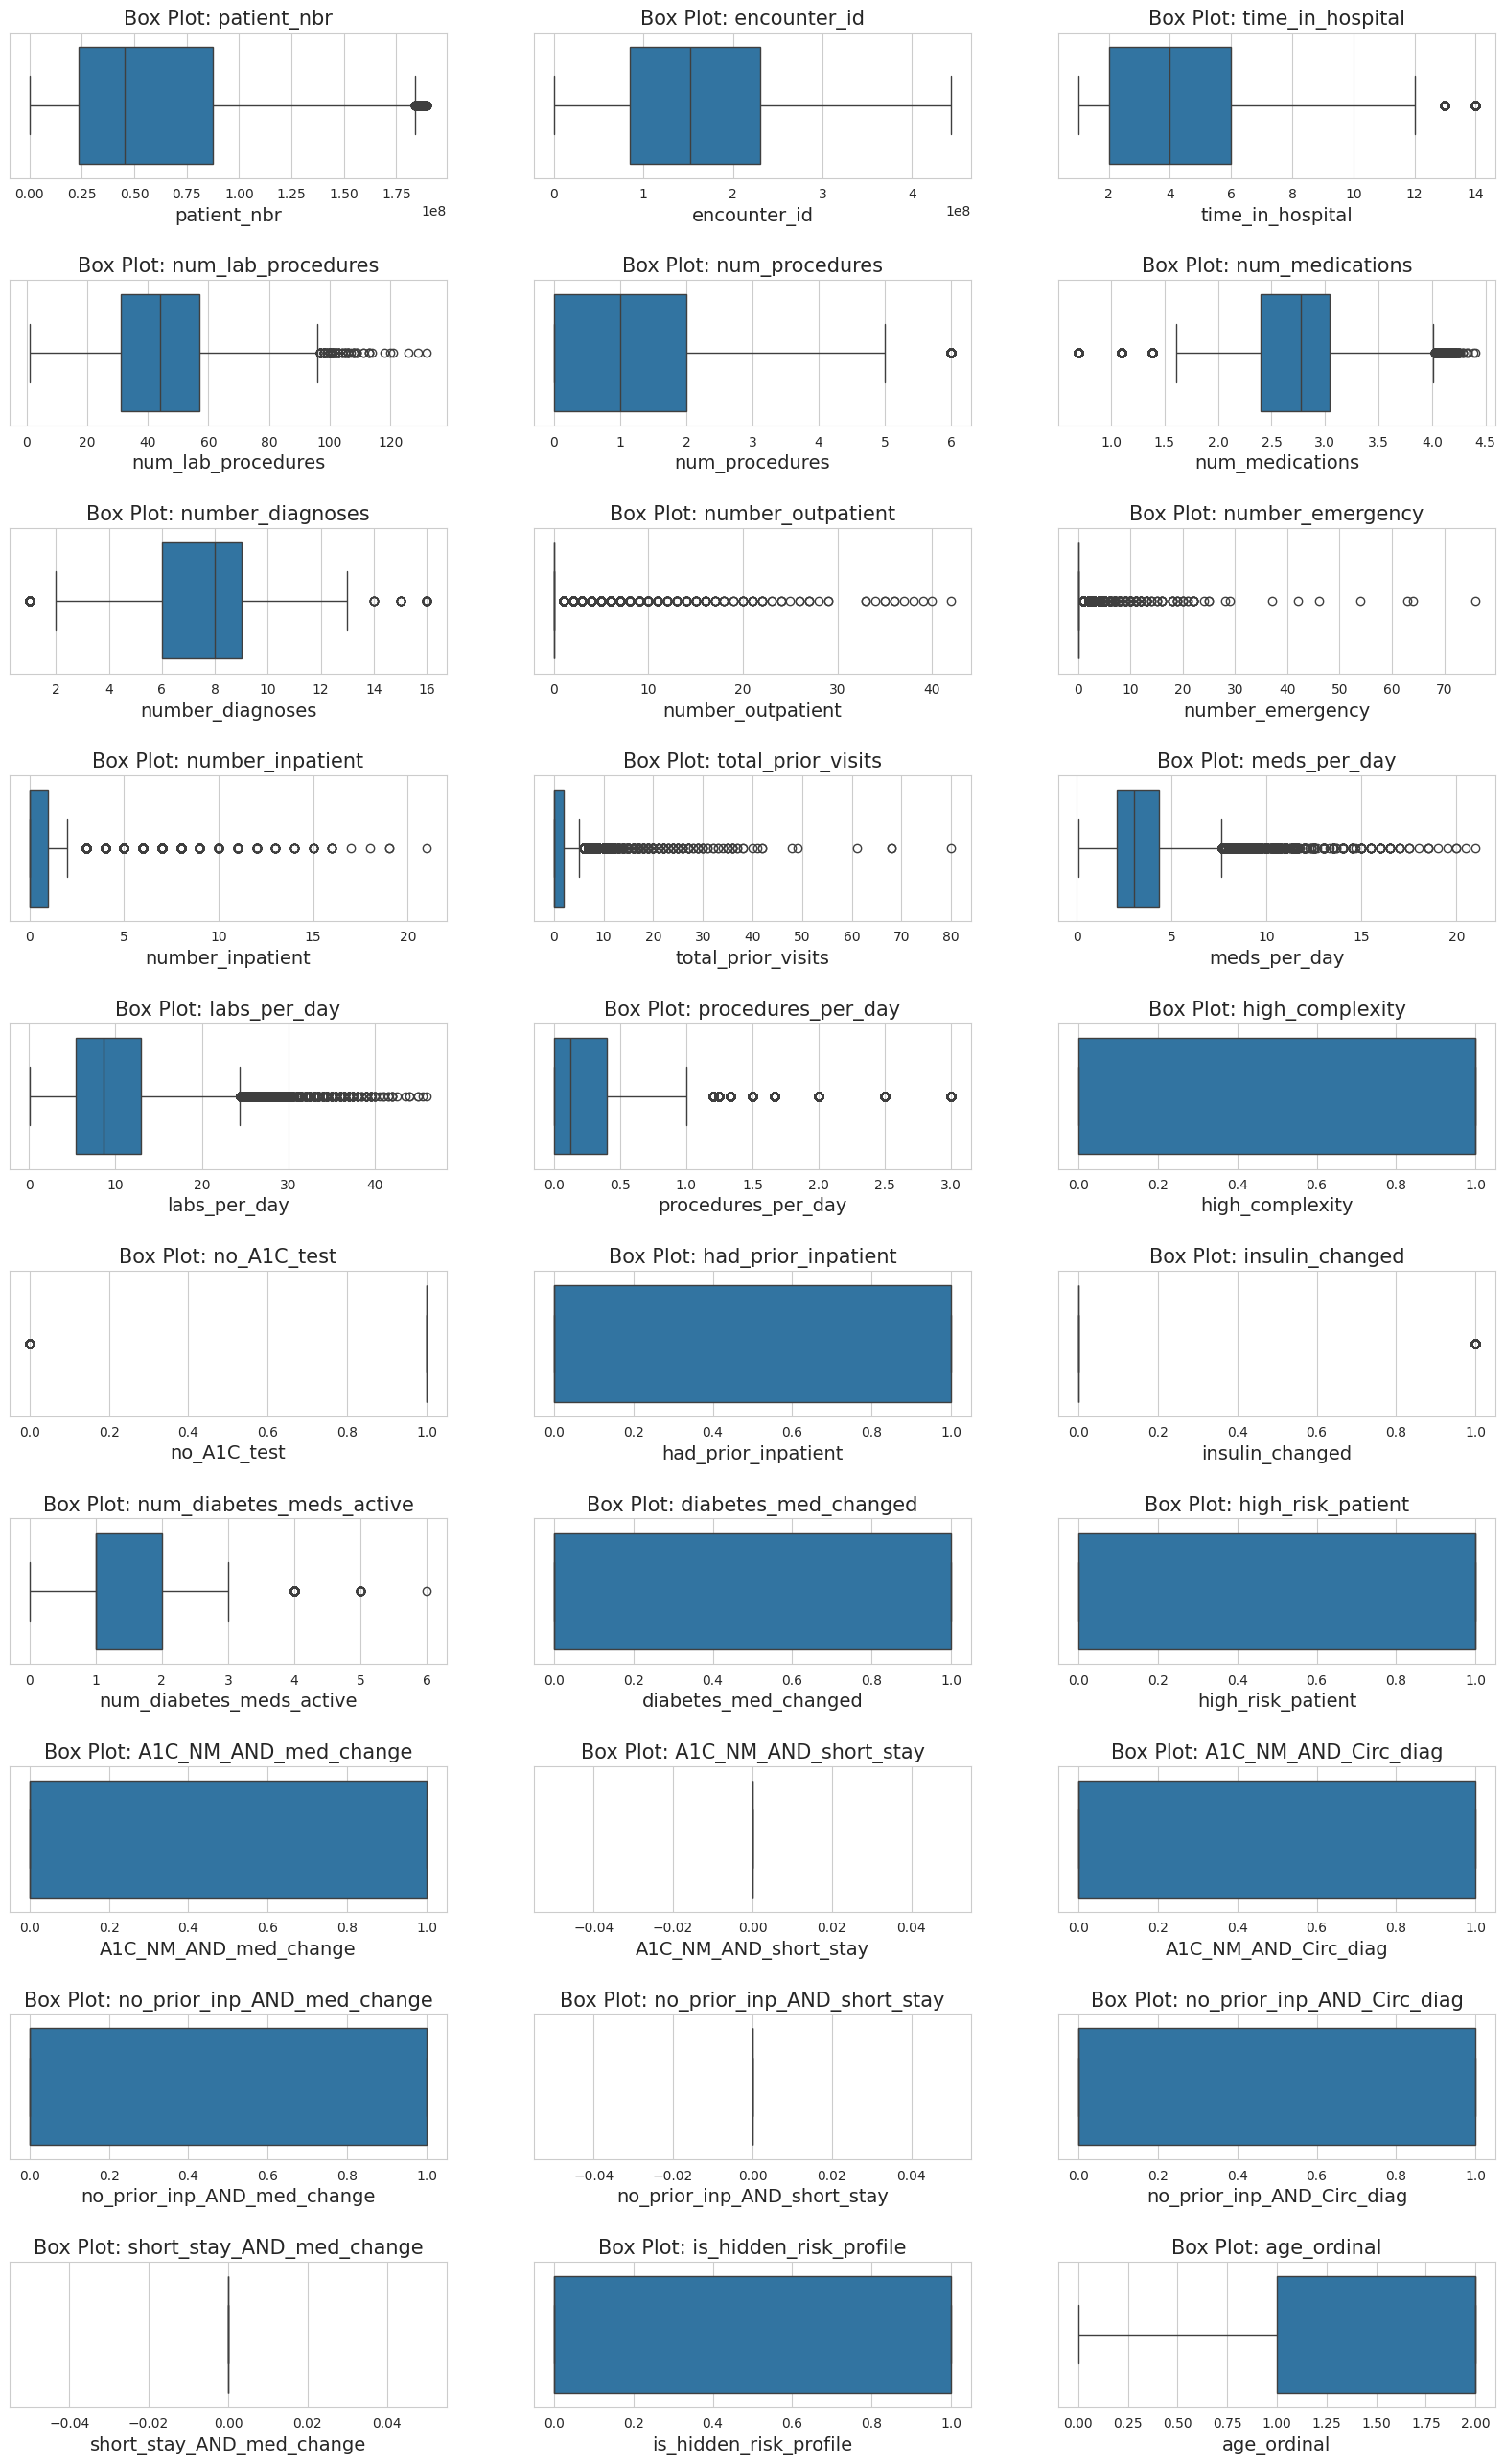

In [ ]:
# ===========================
# Outlier Detection: Boxplots for All Numeric Features
# ===========================

print("="*70)
print("📊 Creating Boxplots for Outlier Detection")
print("="*70)

# Create a large figure to accommodate all subplots
plt.figure(figsize=(20, 200))

def outliers_boxplot(df, verbose=True):
    """
    Creates boxplots for all numeric columns in the dataframe to visualize outliers.
    Also prints summary statistics for each feature.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot
    verbose : bool, default=True
        If True, prints summary statistics for each feature

    Notes:
    ------
    - Each boxplot shows the distribution and potential outliers for one feature
    - Outliers are typically shown as individual points beyond the whiskers
    - The box represents the interquartile range (IQR: 25th to 75th percentile)
    - The line inside the box represents the median
    - Whiskers extend to 1.5 * IQR from the quartiles
    """

    # Select only numeric columns for boxplot analysis
    numeric_cols = df.select_dtypes(include='number').columns

    print(f"Creating boxplots for {len(numeric_cols)} numeric features...")
    print()

    # Iterate through each numeric column
    for i, col in enumerate(numeric_cols):
        # Create subplot for current column
        ax = plt.subplot(60, 3, i+1)

        # Create boxplot
        sb.boxplot(data=df, x=col, ax=ax)

        # Adjust spacing between subplots for better readability
        plt.subplots_adjust(hspace=0.7)

        # Set title and labels
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(f'{col}', fontsize=14)

        # Optional: Print summary statistics
        if verbose and i < 10:  # Print only first 10 to avoid clutter
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outlier_threshold_low = Q1 - 1.5 * IQR
            outlier_threshold_high = Q3 + 1.5 * IQR
            n_outliers = ((df[col] < outlier_threshold_low) | (df[col] > outlier_threshold_high)).sum()

            if n_outliers > 0:
                print(f"  {col}: {n_outliers} potential outliers detected")

# Generate all boxplots
outliers_boxplot(df_new, verbose=True)

print()
print("✅ Boxplots created successfully!")
print("   Review the plots to identify features with significant outliers")
print("   Consider outlier treatment strategies for features with extreme values")
print("="*70)

## 9. Log Transformation for Skewed Features

Apply log transformation to highly skewed numerical features to normalize distributions.

In [ ]:
# ===========================
# Log Transformation for Skewed Features
# ===========================

"""
Why Log Transformation?
-----------------------
- Reduces the impact of extreme values (outliers)
- Makes the distribution more normal/symmetric
- Helps machine learning models that assume normality
- Improves interpretability by putting features on similar scales

Why log1p (log(x+1))?
--------------------
- Regular log(x) fails for x=0 (undefined)
- log1p(x) = log(x+1) handles zeros gracefully
- Preserves the ordering of values
"""

# These columns were identified in the Box Plots as having extreme skewness
# We also include the new features we created that are counts or ratios
cols_to_log_transform = [
    'number_inpatient',      # Prior inpatient visits - highly skewed (many zeros)
    'number_outpatient',     # Prior outpatient visits - highly skewed
    'number_emergency',      # Prior emergency visits - highly skewed
    'num_procedures',        # Number of procedures - right-skewed
    'num_medications',       # Number of medications - long tail distribution
    'total_prior_visits',    # New feature: sum of all prior visits
    'meds_per_day',          # New ratio feature: medications per hospital day
    'labs_per_day',          # New ratio feature: lab procedures per hospital day
    'procedures_per_day'     # New ratio feature: procedures per hospital day
]

print("="*70)
print("🔄 Applying Log1p Transform (Handling Skewness)")
print("="*70)
print(f"Transforming {len(cols_to_log_transform)} features...")
print()

# Track transformation results
transformed_count = 0
skipped_count = 0

# Verify that the column exists before attempting transformation
for col in cols_to_log_transform:
    if col in df_new.columns:
        # Store original stats for comparison (optional)
        original_mean = df_new[col].mean()
        original_std = df_new[col].std()

        # Use np.log1p which is shorthand for log(x+1)
        # This is essential to handle zero values (since log(0) is undefined)
        df_new[col] = np.log1p(df_new[col])

        # New stats after transformation
        new_mean = df_new[col].mean()
        new_std = df_new[col].std()

        print(f"✅ {col}")
        print(f"   Original: mean={original_mean:.2f}, std={original_std:.2f}")
        print(f"   After log1p: mean={new_mean:.2f}, std={new_std:.2f}")

        transformed_count += 1
    else:
        print(f"⚠️ Column '{col}' not found, skipping transform.")
        skipped_count += 1

print()
print("="*70)
print("✅ Log transformation complete!")
print(f"   Transformed: {transformed_count} features")
print(f"   Skipped: {skipped_count} features")
print("   These transformations help reduce skewness and improve model performance")
print("="*70)

🔄 Applying Log1p Transform (Handling Skewness)
Transforming 9 features...

✅ number_inpatient
   Original: mean=0.63, std=1.26
   After log1p: mean=0.32, std=0.51
✅ number_outpatient
   Original: mean=0.37, std=1.27
   After log1p: mean=0.17, std=0.43
✅ number_emergency
   Original: mean=0.20, std=0.94
   After log1p: mean=0.10, std=0.32
✅ num_procedures
   Original: mean=1.33, std=1.70
   After log1p: mean=0.62, std=0.65
✅ num_medications
   Original: mean=2.72, std=0.49
   After log1p: mean=1.30, std=0.14
✅ total_prior_visits
   Original: mean=1.20, std=2.29
   After log1p: mean=0.51, std=0.66
✅ meds_per_day
   Original: mean=3.48, std=1.95
   After log1p: mean=1.42, std=0.40
✅ labs_per_day
   Original: mean=9.73, std=6.15
   After log1p: mean=2.18, std=0.67
✅ procedures_per_day
   Original: mean=0.30, std=0.48
   After log1p: mean=0.22, std=0.28

✅ Log transformation complete!
   Transformed: 9 features
   Skipped: 0 features
   These transformations help reduce skewness and improve

## 10. Define Categorical Features

Identify and list all categorical features including engineered ones.

In [ ]:
# ===========================
# Categorical Features Definition
# ===========================

"""
Categorical Features Strategy
------------------------------
This section defines all categorical (non-numeric) features in the dataset.
These features will need special encoding (e.g., One-Hot Encoding, Label Encoding)
before being used in machine learning models.

Categories include:
- Demographics (race, gender)
- Admission/discharge information
- Medical specialties and payer codes
- Diagnosis categories (primary, secondary, additional)
- A1C test results
- Medication status (dosage changes, yes/no)
"""

print("="*70)
print("📋 Defining Categorical Features")
print("="*70)

cat_features = [
    # ==================
    # Demographics
    # ==================
    'race',                # Patient's race
    'gender',              # Patient's gender

    # ==================
    # Admission and Discharge
    # ==================
    'admission_grouped',         # Grouped admission type (Emergency, Urgent, Elective, etc.)
    'admission_source_grouped',  # Where patient was admitted from
    'discharge_grouped',         # Where patient was discharged to

    # ==================
    # Medical Information
    # ==================
    'specialty_grouped',   # Medical specialty of the admitting physician (grouped)
    # 'specialty_grouped_binned',  # Commented out - decide if you need this AND specialty_grouped
    'payer_grouped',       # Payment/insurance code (grouped)

    # ==================
    # Diagnoses - Categories! (ICD9 codes grouped into categories)
    # ==================
    'diag_1_category',     # Primary diagnosis category
    'diag_2_category',     # Secondary diagnosis category
    'diag_3_category',     # Additional diagnosis category
    'has_diabetes_code',   # Binary indicator for explicit diabetes code
                           # Note: Check data type - if string '0'/'1', keep here;
                           # if numeric 0/1, consider moving to numeric features

    # ==================
    # A1C Test Results
    # ==================
    'A1Cresult',           # HbA1c test result (None/Norm/>7%/>8%)

    # ==================
    # Medications (dosage status)
    # ==================
    'metformin',           # Metformin dosage status (No/Steady/Up/Down)
    'glimepiride',         # Glimepiride dosage status
    'glipizide',           # Glipizide dosage status
    'glyburide',           # Glyburide dosage status
    'pioglitazone',        # Pioglitazone dosage status
    'rosiglitazone',       # Rosiglitazone dosage status
    'insulin',             # Insulin dosage status
    'diabetesMed',         # Patient on diabetes medication? (Yes/No)
    'change',              # Any diabetes medication changed? (Ch/No)
]

# Validate and filter features
print(f"Checking {len(cat_features)} potential categorical features...")
print()

cat_features_original = cat_features.copy()
cat_features = [col for col in cat_features if col in df_new.columns]

# Summary
found_count = len(cat_features)
missing_count = len(cat_features_original) - found_count

print(f"✅ Total categorical features defined: {len(cat_features_original)}")
print(f"✅ Features found in dataframe: {found_count}")

if missing_count > 0:
    print(f"⚠️  Features missing from dataframe: {missing_count}")
    missing_features = [col for col in cat_features_original if col not in df_new.columns]
    for feat in missing_features:
        print(f"   - {feat}")
else:
    print("✅ All defined categorical features are present!")



📋 Defining Categorical Features
Checking 21 potential categorical features...

✅ Total categorical features defined: 21
✅ Features found in dataframe: 21
✅ All defined categorical features are present!


## 11. Prepare Features and Target

Separate features (X) and target variable (y) for model training.

In [ ]:

# ===========================
# Prepare Features (X) and Target (y) for Modeling
# ===========================

"""
Data Preparation for Machine Learning
--------------------------------------
This step separates the dataset into:
- X (features): All columns used to make predictions
- y (target): The variable we're trying to predict (readmission within 30 days)

Columns removed:
- Target variable (readmitted_binary)
- Patient and encounter IDs (not predictive, just identifiers)
"""

print("="*70)
print("🎯 Preparing Data for Machine Learning")
print("="*70)

# Define the target variable (what we're trying to predict)
# Binary classification: 0 = Not readmitted within 30 days, 1 = Readmitted within 30 days
target_variable = 'readmitted_binary'

# Verify target variable exists
if target_variable not in df_new.columns:
    raise ValueError(f"⚠️ Target variable '{target_variable}' not found in dataframe!")

print(f"Target variable: '{target_variable}'")

# Define columns to drop (target + non-predictive identifiers)
columns_to_drop = [
    target_variable,    # Target variable - will be stored separately in y
    'patient_nbr',      # Patient identifier - not predictive, just for tracking
    'encounter_id'      # Encounter identifier - not predictive, just for tracking
]

# Check which columns will actually be dropped
columns_found = [col for col in columns_to_drop if col in df_new.columns]
columns_not_found = [col for col in columns_to_drop if col not in df_new.columns]

print(f"\nColumns to drop: {len(columns_to_drop)}")
for col in columns_found:
    print(f"   ✅ {col}")
for col in columns_not_found:
    print(f"   ⚠️  {col} (not found in dataframe)")

# Separate target variable (y) and features (X)
y = df_new[target_variable]
X = df_new.drop(columns=columns_to_drop, errors='ignore')

# Display summary
print("\n" + "-"*70)
print("📊 Data Summary:")
print("-"*70)
print(f"Total samples: {len(y):,}")
print(f"Total features: {X.shape[1]}")
print(f"Feature names: {list(X.columns[:10])}..." if len(X.columns) > 10 else f"Feature names: {list(X.columns)}")

print("\n" + "-"*70)
print("🎯 Target Variable Distribution:")
print("-"*70)
target_counts = y.value_counts().sort_index()
for class_value in target_counts.index:
    count = target_counts[class_value]
    percentage = (count / len(y)) * 100
    label = "Not readmitted" if class_value == 0 else "Readmitted"
    print(f"   Class {class_value} ({label}): {count:,} ({percentage:.2f}%)")

# Check for class imbalance
imbalance_ratio = target_counts.max() / target_counts.min()
if imbalance_ratio > 2:
    print(f"\n⚠️  Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
else:
    print(f"\n✅ Classes are relatively balanced (ratio: {imbalance_ratio:.2f}:1)")

print("="*70)

🎯 Preparing Data for Machine Learning
Target variable: 'readmitted_binary'

Columns to drop: 3
   ✅ readmitted_binary
   ✅ patient_nbr
   ✅ encounter_id

----------------------------------------------------------------------
📊 Data Summary:
----------------------------------------------------------------------
Total samples: 99,319
Total features: 49
Feature names: ['race', 'gender', 'admission_grouped', 'specialty_grouped', 'admission_source_grouped', 'payer_grouped', 'discharge_grouped', 'time_in_hospital', 'num_lab_procedures', 'num_procedures']...

----------------------------------------------------------------------
🎯 Target Variable Distribution:
----------------------------------------------------------------------
   Class False (Not readmitted): 88,016 (88.62%)
   Class True (Readmitted): 11,303 (11.38%)

⚠️  Class imbalance detected (ratio: 7.79:1)


## 12. Train-Validation-Test Split

Split dataset into training (70%), validation (15%), and test (15%) sets.

In [ ]:
# ===========================
# Train-Validation-Test Split (70/15/15)
# ===========================

print("="*70)
print("✂️  Splitting Data: 70% Train / 15% Validation / 15% Test")
print("="*70)

# Step 1: Main split (70% train / 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,      # 30% for validation + test
    random_state=42,
    stratify=y           # Maintain class distribution
)

# Step 2: Split temporary set into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,      # 50% of 30% = 15% of original data
    random_state=42,
    stratify=y_temp      # Maintain class distribution
)

# Summary
print("\n📊 Split Summary:")
print("-" * 70)
total = len(X)
print(f"Total samples: {total:,}")
print(f"Training:   {len(X_train):>7,} ({len(X_train)/total*100:>5.1f}%)  -  {X_train.shape[1]} features")
print(f"Validation: {len(X_val):>7,} ({len(X_val)/total*100:>5.1f}%)  -  {X_val.shape[1]} features")
print(f"Test:       {len(X_test):>7,} ({len(X_test)/total*100:>5.1f}%)  -  {X_test.shape[1]} features")

# Verify stratification
print("\n🎯 Class Distribution:")
print("-" * 70)
for name, y_set in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    dist = y_set.value_counts(normalize=True).sort_index() * 100
    print(f"{name:>10}: Class 0: {dist[0]:.2f}%  |  Class 1: {dist[1]:.2f}%")

print("="*70)
print("✅ Data split completed successfully!")
print("="*70)

✂️  Splitting Data: 70% Train / 15% Validation / 15% Test

📊 Split Summary:
----------------------------------------------------------------------
Total samples: 99,319
Training:    69,523 ( 70.0%)  -  49 features
Validation:  14,898 ( 15.0%)  -  49 features
Test:        14,898 ( 15.0%)  -  49 features

🎯 Class Distribution:
----------------------------------------------------------------------
     Train: Class 0: 88.62%  |  Class 1: 11.38%
       Val: Class 0: 88.62%  |  Class 1: 11.38%
      Test: Class 0: 88.62%  |  Class 1: 11.38%
✅ Data split completed successfully!


## 13. One-Hot Encoding

Convert categorical variables to numerical format using one-hot encoding with alignment across splits.

In [ ]:
# ===========================
# One-Hot Encoding with Alignment
# ===========================

print("\n" + "="*70)
print("🔧 One-Hot Encoding: Train/Validation/Test Splits")
print("="*70)

# Note: Assumes 'cat_features' list is already defined

# Step 1: Encode all three sets
print(f"Encoding {len(cat_features)} categorical features...")
X_train_ohe = pd.get_dummies(X_train.copy(), columns=cat_features, drop_first=True, dtype=int)
X_val_ohe = pd.get_dummies(X_val.copy(), columns=cat_features, drop_first=True, dtype=int)
X_test_ohe = pd.get_dummies(X_test.copy(), columns=cat_features, drop_first=True, dtype=int)

print(f"Before alignment: Train={X_train_ohe.shape}, Val={X_val_ohe.shape}, Test={X_test_ohe.shape}")

# Step 2: *** CRITICAL ALIGNMENT STEP ***
# Align val/test to have the EXACT same columns as training
# - Missing columns → filled with 0 (category never seen in training)
# - Extra columns → dropped (model not trained on them)
print("\n🔄 Aligning validation and test sets to training structure...")
X_val_ohe = X_val_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f"After alignment:  Train={X_train_ohe.shape}, Val={X_val_ohe.shape}, Test={X_test_ohe.shape}")

# Step 3: Verify
assert X_train_ohe.shape[1] == X_val_ohe.shape[1] == X_test_ohe.shape[1], "Column mismatch!"
print("\n✅ One-hot encoding complete! All sets aligned and ready for modeling.")
print("="*70)


🔧 One-Hot Encoding: Train/Validation/Test Splits
Encoding 21 categorical features...
Before alignment: Train=(69523, 116), Val=(14898, 116), Test=(14898, 116)

🔄 Aligning validation and test sets to training structure...
After alignment:  Train=(69523, 116), Val=(14898, 116), Test=(14898, 116)

✅ One-hot encoding complete! All sets aligned and ready for modeling.


## 14. Outlier Handling (Feature Capping)

Cap outliers using quantile-based thresholds to reduce extreme values' impact.

In [ ]:
# ===========================
# Feature Capping by Quantiles (Outlier Treatment)
# ===========================

def cap_features_by_quantile_3(X_train, X_val, X_test, cols_to_cap, lower_quantile=0.01, upper_quantile=0.99):
    """
    Caps (clips) specific columns in three datasets to reduce the impact of outliers.

    The function learns the capping boundaries (quantiles) ONLY from the training set (X_train)
    and applies them consistently to X_train, X_val, and X_test.

    Parameters:
    -----------
    X_train : pd.DataFrame
        Training set features
    X_val : pd.DataFrame
        Validation set features
    X_test : pd.DataFrame
        Test set features
    cols_to_cap : list
        List of column names to cap
    lower_quantile : float, default=0.01
        Lower quantile threshold (e.g., 0.01 = 1st percentile)
    upper_quantile : float, default=0.99
        Upper quantile threshold (e.g., 0.99 = 99th percentile)

    Returns:
    --------
    tuple of pd.DataFrame
        Capped versions of X_train, X_val, X_test

    Important:
    ----------
    - Boundaries are learned ONLY from training data to prevent data leakage
    - Values below lower_quantile are set to lower_quantile value
    - Values above upper_quantile are set to upper_quantile value
    - This reduces the impact of extreme outliers on model training
    """

    print(f"\n{'='*70}")
    print(f"🔒 Capping features at {lower_quantile*100}% and {upper_quantile*100}% quantiles")
    print(f"{'='*70}")

    # Create copies to avoid SettingWithCopyWarning
    X_train_capped = X_train.copy()
    X_val_capped = X_val.copy()
    X_test_capped = X_test.copy()

    for col in cols_to_cap:
        if col in X_train_capped.columns:
            # Step 1: Learn the boundaries ONLY from the training set
            lower_limit = X_train_capped[col].quantile(lower_quantile)
            upper_limit = X_train_capped[col].quantile(upper_quantile)

            print(f"  ✅ {col}: Limits learned [Lower: {lower_limit:.2f}, Upper: {upper_limit:.2f}]")

            # Step 2: Apply capping (using .clip()) to all three sets
            X_train_capped[col] = X_train_capped[col].clip(lower=lower_limit, upper=upper_limit)
            X_val_capped[col] = X_val_capped[col].clip(lower=lower_limit, upper=upper_limit)
            X_test_capped[col] = X_test_capped[col].clip(lower=lower_limit, upper=upper_limit)
        else:
            print(f"  ⚠️  Warning: Column '{col}' not found in DataFrame, skipping.")

    print(f"{'='*70}")
    return X_train_capped, X_val_capped, X_test_capped


# ================================================================
# Apply Feature Capping to One-Hot Encoded Sets
# ================================================================

print("\n" + "="*70)
print("⭐ Applying Feature Capping to Reduce Outlier Impact")
print("="*70)

# Step 1: Define columns that require capping
# These are columns that did NOT undergo log transformation
columns_to_cap = [
    'time_in_hospital',      # Hospital stay duration (days)
    'num_lab_procedures',    # Number of lab tests performed
    'number_diagnoses'       # Total number of diagnoses
]

print(f"Columns to cap: {columns_to_cap}")
print(f"Capping strategy: Remove extreme outliers while preserving data structure")

# Step 2: Apply the capping function to the one-hot encoded sets
X_train_capped, X_val_capped, X_test_capped = cap_features_by_quantile_3(
    X_train_ohe,
    X_val_ohe,
    X_test_ohe,
    cols_to_cap=columns_to_cap,
    lower_quantile=0.01,  # Cap values below 1st percentile
    upper_quantile=0.99   # Cap values above 99th percentile
)

# Step 3: Verify results
print("\n" + "-"*70)
print("📊 Summary:")
print("-"*70)
print(f"✅ Capping complete for one-hot encoded sets")
print(f"   X_train_capped shape: {X_train_capped.shape}")
print(f"   X_val_capped shape:   {X_val_capped.shape}")
print(f"   X_test_capped shape:  {X_test_capped.shape}")
print(f"   Features capped: {len(columns_to_cap)}")
print("="*70)


⭐ Applying Feature Capping to Reduce Outlier Impact
Columns to cap: ['time_in_hospital', 'num_lab_procedures', 'number_diagnoses']
Capping strategy: Remove extreme outliers while preserving data structure

🔒 Capping features at 1.0% and 99.0% quantiles
  ✅ time_in_hospital: Limits learned [Lower: 1.00, Upper: 13.00]
  ✅ num_lab_procedures: Limits learned [Lower: 1.00, Upper: 84.00]
  ✅ number_diagnoses: Limits learned [Lower: 2.00, Upper: 9.00]

----------------------------------------------------------------------
📊 Summary:
----------------------------------------------------------------------
✅ Capping complete for one-hot encoded sets
   X_train_capped shape: (69523, 116)
   X_val_capped shape:   (14898, 116)
   X_test_capped shape:  (14898, 116)
   Features capped: 3


## 15. Feature Scaling (Standardization)

Standardize numerical features to have mean=0 and std=1 for improved model convergence.

In [ ]:
# ===========================
# Feature Scaling (Standardization)
# ===========================

"""
Why Scale Features?
-------------------
- Many ML algorithms (e.g., Logistic Regression, SVM, Neural Networks) are sensitive to feature scales
- Features with larger ranges can dominate the learning process
- StandardScaler transforms features to have mean=0 and standard deviation=1
- This puts all features on the same scale, improving model performance

Important: Fit on training data only to prevent data leakage!
"""

print("\n" + "="*70)
print("📏 Scaling Features Using StandardScaler")
print("="*70)

# Step 1: Initialize the Scaler
scaler = StandardScaler()

# Step 2: Learn the mean and standard deviation ONLY from the training set (X_train_capped)
#         and immediately apply the transformation (this is what fit_transform does)
print("Learning scaling parameters from training set...")
X_train_scaled = scaler.fit_transform(X_train_capped)
print(f"✅ Training set scaled: {X_train_scaled.shape}")

# Step 3: Apply the SAME scaling (using training statistics) to the validation set
print("Applying training scaling parameters to validation set...")
X_val_scaled = scaler.transform(X_val_capped)
print(f"✅ Validation set scaled: {X_val_scaled.shape}")

# Step 4: Apply the SAME scaling (using training statistics) to the test set
print("Applying training scaling parameters to test set...")
X_test_scaled = scaler.transform(X_test_capped)
print(f"✅ Test set scaled: {X_test_scaled.shape}")

# Verification
print("\n" + "-"*70)
print("📊 Scaling Summary:")
print("-"*70)
print(f"Training set:   {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set:       {X_test_scaled.shape}")
print("\n✅ Scaling complete! Data is ready for ML models (e.g., Logistic Regression, SVM)")

# Note: The output (e.g., X_train_scaled) is a NumPy array, not a DataFrame.
# This is the exact format that scikit-learn expects for model training.
print("\nℹ️  Note: Scaled data is in NumPy array format (required by scikit-learn)")
print("="*70)


📏 Scaling Features Using StandardScaler
Learning scaling parameters from training set...
✅ Training set scaled: (69523, 116)
Applying training scaling parameters to validation set...
✅ Validation set scaled: (14898, 116)
Applying training scaling parameters to test set...
✅ Test set scaled: (14898, 116)

----------------------------------------------------------------------
📊 Scaling Summary:
----------------------------------------------------------------------
Training set:   (69523, 116)
Validation set: (14898, 116)
Test set:       (14898, 116)

✅ Scaling complete! Data is ready for ML models (e.g., Logistic Regression, SVM)

ℹ️  Note: Scaled data is in NumPy array format (required by scikit-learn)


## 16. Class Balancing Strategy Comparison

Compare different class balancing techniques: SMOTE, Random Oversampling, and Class Weights.

In [ ]:
# ===========================
# Class Balancing Strategy Comparison
# ===========================

"""
Testing Different Balancing Techniques
---------------------------------------
This script tests multiple strategies to handle class imbalance in the dataset:
1. SMOTE (Synthetic Minority Over-sampling Technique)
2. Random Over-sampling
3. Random Under-sampling
4. No Balancing (baseline)
"""



print("=" * 80)
print("STEP 5.5: Testing Different Class Balancing Techniques")
print("=" * 80)

# ================================================================
# 0. Check Target Variable Distribution
# ================================================================
print("\n0️⃣  Original Training Set - Target Variable Distribution:")
print(y_train.value_counts())
print(f"   Class imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

# ================================================================
# 1. Define Balancing Methods to Test
# ================================================================
balancing_methods = {
    'SMOTE': SMOTE(random_state=42),                          # Synthetic samples of minority class
    'RandomOverSampler': RandomOverSampler(random_state=42),  # Duplicate minority class samples
    'RandomUnderSampler': RandomUnderSampler(random_state=42),# Remove majority class samples
    'No Balancing': None                                       # Baseline (original distribution)
}

print(f"\n1️⃣  Testing {len(balancing_methods)} balancing strategies:")
for method_name in balancing_methods.keys():
    print(f"   • {method_name}")

# ================================================================
# 2. Initialize Results Storage
# ================================================================
results = {}

# ================================================================
# 3. Test Each Balancing Method
# ================================================================
# Pipeline: (OHE + Capped Data) → Balance → Scale → Train → Evaluate

for name, method in balancing_methods.items():
    print(f"\n{'='*80}")
    print(f"🧪 Testing: {name}")
    print(f"{'='*80}")

    # --- Step 3a: Apply Balancing (if any) ---
    # Use data that has undergone OHE and capping (but NOT scaling yet)
    if method is None:
        # No balancing - use original training data
        X_train_resampled = X_train_capped.copy()
        y_train_resampled = y_train.copy()
    else:
        # Apply balancing to the encoded and capped data (not yet scaled)
        X_train_resampled, y_train_resampled = method.fit_resample(X_train_capped, y_train)

    print(f"Training set size after {name}: {X_train_resampled.shape}")
    print(f"Class distribution after balancing:")
    print(pd.Series(y_train_resampled).value_counts())

    # --- Step 3b: Scale Data AFTER Balancing ---
    # Initialize a NEW scaler inside the loop (important!)
    scaler = StandardScaler()

    # Learn scaling parameters ONLY from the balanced training set
    X_train_scaled = scaler.fit_transform(X_train_resampled)

    # Apply the same scaling to the validation set
    # NOTE: Validation set is NEVER balanced (we evaluate on real-world distribution)
    X_val_scaled = scaler.transform(X_val_capped)

    # --- Step 3c: Train Model ---
    model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
    model.fit(X_train_scaled, y_train_resampled)

    # --- Step 3d: Evaluate on Validation Set ---
    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Calculate metrics
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred)

    # Calculate PR-AUC (Precision-Recall Area Under Curve)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_proba)
    pr_auc = auc(recall_curve, precision_curve)

    # Store results
    results[name] = {
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'PR-AUC': pr_auc
    }

    print(f"\n📊 Validation Results:")
    print(f"   Recall:    {recall:.4f} ← % of actual readmissions caught")
    print(f"   Precision: {precision:.4f} ← % of predicted readmissions that are correct")
    print(f"   F1-Score:  {f1:.4f} ← Harmonic mean of Precision & Recall")
    print(f"   PR-AUC:    {pr_auc:.4f} ← Overall performance metric")

# ================================================================
# 4. Compare All Methods and Rank by RECALL
# ================================================================
print("\n" + "=" * 80)
print("📊 COMPARISON - ALL METHODS (Sorted by Recall)")
print("=" * 80)

results_df = pd.DataFrame(results).T.sort_values(by='Recall', ascending=False)
print(results_df.to_string())

# ================================================================
# 5. Select Best Method Based on RECALL
# ================================================================
best_method_name = results_df.index[0]

print(f"\n{'='*80}")
print(f"🏆 BEST METHOD (by Recall): {best_method_name}")
print(f"{'='*80}")
print(f"   Recall:    {results_df.loc[best_method_name, 'Recall']:.4f}")
print(f"   Precision: {results_df.loc[best_method_name, 'Precision']:.4f}")
print(f"   F1-Score:  {results_df.loc[best_method_name, 'F1-Score']:.4f}")
print(f"   PR-AUC:    {results_df.loc[best_method_name, 'PR-AUC']:.4f}")

# Clinical interpretation
recall_pct = results_df.loc[best_method_name, 'Recall'] * 100
precision_pct = results_df.loc[best_method_name, 'Precision'] * 100

print(f"\n💡 Clinical Interpretation:")
print(f"   • Out of 100 actual readmissions, we catch: {recall_pct:.1f}")
print(f"   • Out of 100 predicted readmissions, {precision_pct:.1f} are correct")
print(f"\n   Why Recall matters in healthcare:")
print(f"   Missing a high-risk patient (false negative) is more costly than")
print(f"   flagging a low-risk patient for review (false positive)")

# ================================================================
# 6. Create FINAL Processed Sets Using Best Method
# ================================================================
print(f"\n{'='*80}")
print(f"🎯 CREATING FINAL PROCESSED SETS (Using {best_method_name})")
print(f"{'='*80}")

# Step 6a: Apply best balancing method to training set
if best_method_name == 'No Balancing':
    X_train_final_balanced = X_train_capped.copy()
    y_train_final_balanced = y_train.copy()
    print("✓ Using original (unbalanced) training data")
else:
    best_method = balancing_methods[best_method_name]
    X_train_final_balanced, y_train_final_balanced = best_method.fit_resample(
        X_train_capped,
        y_train
    )
    print(f"✓ Applied {best_method_name} to training data")

print(f"   Training samples after balancing: {X_train_final_balanced.shape[0]:,}")
print(f"   Class distribution:")
print(pd.Series(y_train_final_balanced).value_counts())

# Step 6b: Apply final scaling
print("\n✓ Applying final scaling...")
final_scaler = StandardScaler()

# Learn scaling parameters ONLY from the final balanced training set
X_train_final_scaled = final_scaler.fit_transform(X_train_final_balanced)

# Apply the same scaling to validation and test sets (which remain unbalanced)
X_val_final_scaled = final_scaler.transform(X_val_capped)
X_test_final_scaled = final_scaler.transform(X_test_capped)

# ================================================================
# 7. Final Summary
# ================================================================
print("\n" + "=" * 80)
print("✅ FINAL PROCESSED SETS - READY FOR MODELING")
print("=" * 80)
print(f"Training set:   {X_train_final_scaled.shape}")
print(f"   Samples: {X_train_final_scaled.shape[0]:,}")
print(f"   Features: {X_train_final_scaled.shape[1]:,}")
print(f"   Target shape: {y_train_final_balanced.shape}")
print(f"\nValidation set: {X_val_final_scaled.shape}")
print(f"   Samples: {X_val_final_scaled.shape[0]:,}")
print(f"\nTest set:       {X_test_final_scaled.shape}")
print(f"   Samples: {X_test_final_scaled.shape[0]:,}")



STEP 5.5: Testing Different Class Balancing Techniques

0️⃣  Original Training Set - Target Variable Distribution:
readmitted_binary
False    61611
True      7912
Name: count, dtype: int64
   Class imbalance ratio: 7.79:1

1️⃣  Testing 4 balancing strategies:
   • SMOTE
   • RandomOverSampler
   • RandomUnderSampler
   • No Balancing

🧪 Testing: SMOTE
Training set size after SMOTE: (123222, 116)
Class distribution after balancing:
readmitted_binary
False    61611
True     61611
Name: count, dtype: int64

📊 Validation Results:
   Recall:    0.0855 ← % of actual readmissions caught
   Precision: 0.1762 ← % of predicted readmissions that are correct
   F1-Score:  0.1151 ← Harmonic mean of Precision & Recall
   PR-AUC:    0.1385 ← Overall performance metric

🧪 Testing: RandomOverSampler
Training set size after RandomOverSampler: (123222, 116)
Class distribution after balancing:
readmitted_binary
False    61611
True     61611
Name: count, dtype: int64

📊 Validation Results:
   Recall:    0.

## 17. Feature Selection Using Random Forest

Select most important features using Random Forest feature importance scores.

In [ ]:
# ===========================
# Feature Selection Using Random Forest Feature Importance
# ===========================

"""
Feature Selection Strategy
--------------------------
Using Random Forest to identify the most important features:
1. Train Random Forest on the fully processed data
2. Extract feature importance scores
3. Select top N features (default: 50)
4. Create final datasets with only selected features

Benefits:
- Reduces model complexity and training time
- Reduces overfitting risk
- Improves model interpretability
- May improve performance by removing noise
"""

print("=" * 80)
print("🔍 FEATURE SELECTION: Random Forest Feature Importance")
print("=" * 80)

# ================================================================
# Step 1: Train Random Forest for Feature Selection
# ================================================================
print("\n1️⃣  Training Random Forest for feature selection...")
print("   (Using the fully processed, balanced, and scaled training data)")

rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    random_state=42,       # For reproducibility
    n_jobs=-1,            # Use all available CPU cores
    max_depth=10          # Limit tree depth to prevent overfitting
)

# *** Fix 1: Train the model on the final scaled and balanced data ***
# (X_train_balanced_final was before scaling, this is better)
rf.fit(X_train_final_scaled, y_train_final_balanced)
print(f"   ✓ Random Forest trained on {X_train_final_scaled.shape[0]:,} samples")
print(f"   ✓ Number of features: {X_train_final_scaled.shape[1]}")

# ================================================================
# Step 2: Extract Feature Importances
# ================================================================
print("\n2️⃣  Extracting feature importances...")

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_capped.columns,  # <--- This is the critical fix
    'Importance': importances
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(f"   ✓ Feature importances calculated for {len(feature_importance_df)} features")

# ================================================================
# Step 3: Select Top N Features
# ================================================================
TOP_N_FEATURES = 50

print(f"\n3️⃣  Top {TOP_N_FEATURES} Most Important Features")
print("=" * 80)
print(feature_importance_df.head(TOP_N_FEATURES).to_string(index=False))
print("=" * 80)

selected_features_list = feature_importance_df.head(TOP_N_FEATURES)['Feature'].tolist()

cumulative_importance = feature_importance_df.head(TOP_N_FEATURES)['Importance'].sum()
print(f"\n📊 Cumulative importance of top {TOP_N_FEATURES} features: {cumulative_importance:.4f}")
print(f"   ({cumulative_importance*100:.2f}% of total importance captured)")

# ================================================================
# Step 4: Create Final Datasets with Selected Features Only
# ================================================================
print(f"\n{'='*80}")
print("4️⃣  Creating Final Datasets (with selected features only)")
print(f"{'='*80}")


# Convert X_train_final_scaled back to DataFrame
X_train_scaled_df = pd.DataFrame(
    X_train_final_scaled,
    columns=X_train_capped.columns  # Use the same correct columns
)

# Convert X_val_final_scaled back to DataFrame
X_val_scaled_df = pd.DataFrame(
    X_val_final_scaled,    # <--- Fix 3a: Use correct variable name
    columns=X_train_capped.columns
)

# Convert X_test_final_scaled back to DataFrame
X_test_scaled_df = pd.DataFrame(
    X_test_final_scaled,   # <--- Fix 3b: Use correct variable name
    columns=X_train_capped.columns
)

print("   ✓ Converted NumPy arrays back to DataFrames")

X_train_selected = X_train_scaled_df[selected_features_list]
X_val_selected = X_val_scaled_df[selected_features_list]      # <--- Fix 4a: Updated variable name
X_test_selected = X_test_scaled_df[selected_features_list]

y_train_selected = y_train_final_balanced  # Balanced target
y_val_selected = y_val                     # Original validation target
y_test_selected = y_test                   # Original test target

print("   ✓ Selected top features from all datasets")

# ================================================================
# Step 5: Summary
# ================================================================
print(f"\n{'='*80}")
print("📊 FINAL DATASETS SUMMARY (with selected features)")
print(f"{'='*80}")

print(f"\nTraining Set:")
print(f"   X_train_selected: {X_train_selected.shape}")
print(f"   - Samples: {X_train_selected.shape[0]:,}")
print(f"   - Features: {X_train_selected.shape[1]}")
print(f"   y_train_selected: {y_train_selected.shape}")

print(f"\nValidation Set:")
print(f"   X_val_selected: {X_val_selected.shape}")      # <--- Fix 4b: Updated variable name
print(f"   - Samples: {X_val_selected.shape[0]:,}")
print(f"   - Features: {X_val_selected.shape[1]}")
print(f"   y_val_selected: {y_val_selected.shape}")

print(f"\nTest Set:")
print(f"   X_test_selected: {X_test_selected.shape}")
print(f"   - Samples: {X_test_selected.shape[0]:,}")
print(f"   - Features: {X_test_selected.shape[1]}")
print(f"   y_test_selected: {y_test_selected.shape}")

# Feature reduction summary
original_features = X_train_final_scaled.shape[1]
selected_features = X_train_selected.shape[1]
reduction_pct = (1 - selected_features / original_features) * 100

print(f"\n📉 Feature Reduction:")
print(f"   Original features: {original_features}")
print(f"   Selected features: {selected_features}")
print(f"   Reduction: {reduction_pct:.1f}%")

print("\n" + "=" * 80)
print("✅ Feature Selection Complete! Ready for Final Modeling")
print("=" * 80)
print("\nNext steps:")
print("   1. Train models using X_train_selected & y_train_selected")
print("   2. Validate using X_val_selected & y_val_selected")
print("   3. Final test using X_test_selected & y_test_selected (once only!)")

🔍 FEATURE SELECTION: Random Forest Feature Importance

1️⃣  Training Random Forest for feature selection...
   (Using the fully processed, balanced, and scaled training data)
   ✓ Random Forest trained on 123,222 samples
   ✓ Number of features: 116

2️⃣  Extracting feature importances...
   ✓ Feature importances calculated for 116 features

3️⃣  Top 50 Most Important Features
                               Feature  Importance
                      number_inpatient    0.102097
                    total_prior_visits    0.081011
                   had_prior_inpatient    0.076629
discharge_grouped_Transfer_to_Facility    0.064369
                          labs_per_day    0.036979
                          meds_per_day    0.036319
                       num_medications    0.035088
                    num_lab_procedures    0.033975
                      number_diagnoses    0.031699
                     high_risk_patient    0.030909
                      time_in_hospital    0.027459
        

# 18. Train Multiple Machine Learning Models

Train and evaluate 5 different ML algorithms: Logistic Regression, Decision Tree, Random Forest, XGBoost, and CatBoost.

In [ ]:
# ===========================
# Training and Evaluating Multiple Models
# ===========================

# הוספנו ייבוא עבור עצירה מוקדמת של LGBM
from lightgbm import early_stopping
import time
import pandas as pd
from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    auc
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print("=" * 80)
print("🚀 TRAINING AND EVALUATING MODELS")
print("=" * 80)

# ===============================================================
# Step 1: Define Data Variables
# ===============================================================

X_train_processed = X_train_selected
y_train_processed = y_train_selected
X_val_processed = X_val_selected
y_val_processed = y_val_selected

print(f"\n📊 Dataset Information (Processed for all models):")
print(f"   Number of features: {X_train_processed.shape[1]}")
print(f"   Training samples:   {X_train_processed.shape[0]:,}")
print(f"   Validation samples: {X_val_processed.shape[0]:,}")

# ===============================================================
# Step 2: Define Models to Test
# ===============================================================
print("\n" + "=" * 80)
print("🤖 Models to Evaluate:")
print("=" * 80)

models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        max_depth=10
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=15
    ),
    "AdaBoost": AdaBoostClassifier(
        random_state=42,
        n_estimators=100
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=5
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        eval_metric='logloss',
        early_stopping_rounds=50
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        verbose=-1
    ),
    "CatBoost (Processed)": CatBoostClassifier(
        random_state=42,
        iterations=500,
        depth=6,
        learning_rate=0.05,
        eval_metric='AUC',
        verbose=False,
        early_stopping_rounds=50
    )
}

for name in models.keys():
    print(f"   • {name}")

# ===============================================================
# Step 3: Initialize Results Storage
# ===============================================================
results = {}

# ===============================================================
# Step 4: Train and Evaluate Each Model
# ===============================================================
print("\n" + "=" * 80)
print("🏋️ TRAINING MODELS (OHE/Scaled/Balanced/Feature-Selected Data)")
print("=" * 80)

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    start_time = time.time()

    # --- Train on processed data ---
    if name in ["XGBoost", "CatBoost (Processed)"]:
        # XGBoost ו-CatBoost מקבלים 'verbose' ב-fit
        model.fit(X_train_processed, y_train_processed,
                  eval_set=[(X_val_processed, y_val_processed)],
                  verbose=False)

    elif name == "LightGBM":
        # LightGBM
        model.fit(X_train_processed, y_train_processed,
                  eval_set=[(X_val_processed, y_val_processed)],
                  eval_metric='aucpr', #for PR-AUC
                  callbacks=[early_stopping(50, verbose=False)]) # שימוש ב-callback

    else:
        # (DT, RF, Ada, GB)
        model.fit(X_train_processed, y_train_processed)


    # --- Predict on processed validation data ---
    y_pred = model.predict(X_val_processed)
    y_proba = model.predict_proba(X_val_processed)[:, 1]

    end_time = time.time()
    train_time = end_time - start_time

    # --- Calculate metrics ---
    recall = recall_score(y_val_processed, y_pred)
    precision = precision_score(y_val_processed, y_pred, zero_division=0)
    f1 = f1_score(y_val_processed, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val_processed, y_proba)
    pr_auc = auc(recall_curve, precision_curve)

    # --- Store results ---
    results[name] = {
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1,
        "PR-AUC": pr_auc,
        "Train Time (s)": train_time
    }

    # --- Print summary ---
    print(f"\n⏱️  Training Time: {train_time:.2f} seconds")
    print(f"\n📊 Metrics on Validation Set (Processed):")
    print(f"   Recall:    {recall:.4f} (% of readmissions caught)")
    print(f"   Precision: {precision:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   PR-AUC:    {pr_auc:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(
        y_val_processed,
        y_pred,
        target_names=['Not Readmitted (0)', 'Readmitted (1)'],
        zero_division=0
    ))

# ===============================================================
# Step 5: Final Model Comparison
# ===============================================================
print("\n" + "=" * 80)
print("🏆 FINAL MODEL COMPARISON (All Models on Processed Data)")
print("=" * 80)

results_df = pd.DataFrame(results).T

# Sort by Recall
results_df_recall = results_df.sort_values(by='Recall', ascending=False)
print("\n📊 Sorted by Recall (Catching Readmissions - Primary Goal)")
print("=" * 80)
print(results_df_recall.to_string())

# Sort by PR-AUC
results_df_pr = results_df.sort_values(by='PR-AUC', ascending=False)
print("\n📊 Sorted by PR-AUC (Overall Balance)")
print("=" * 80)
print(results_df_pr.to_string())

print("\n" + "=" * 80)
print("✅ Model Training and Evaluation Complete!")
print("=" * 80)

🚀 TRAINING AND EVALUATING MODELS

📊 Dataset Information (Processed for all models):
   Number of features: 50
   Training samples:   123,222
   Validation samples: 14,898

🤖 Models to Evaluate:
   • Decision Tree
   • Random Forest
   • AdaBoost
   • Gradient Boosting
   • XGBoost
   • LightGBM
   • CatBoost (Processed)

🏋️ TRAINING MODELS (OHE/Scaled/Balanced/Feature-Selected Data)

Training: Decision Tree

⏱️  Training Time: 1.08 seconds

📊 Metrics on Validation Set (Processed):
   Recall:    0.5908 (% of readmissions caught)
   Precision: 0.1571
   F1-Score:  0.2482
   PR-AUC:    0.1780

Detailed Classification Report:
                    precision    recall  f1-score   support

Not Readmitted (0)       0.92      0.59      0.72     13202
    Readmitted (1)       0.16      0.59      0.25      1696

          accuracy                           0.59     14898
         macro avg       0.54      0.59      0.48     14898
      weighted avg       0.83      0.59      0.67     14898


Traini

## 19. Hyperparameter Tuning with Optuna (CatBoost)

Optimize CatBoost hyperparameters using Optuna's Bayesian optimization approach.

In [ ]:
# ===========================================================================
# COMPLETE HYPERPARAMETER OPTIMIZATION CODE
# CatBoost with Optuna - Trained on PROCESSED Data
# ===========================================================================

# *** 1. הגדרת הנתונים הנכונים לכוונון ***
# אלו הנתונים שעברו OHE, Capping, Balancing, Scaling, ו-Feature Selection
X_train_optuna = X_train_selected
y_train_optuna = y_train_selected
X_val_optuna = X_val_selected
y_val_optuna = y_val_selected # זהו ה-y המקורי, הלא-מאוזן, לולידציה

print(f"✅ Training set:   {X_train_optuna.shape[0]:,} samples, {X_train_optuna.shape[1]} features")
print(f"✅ Validation set: {X_val_optuna.shape[0]:,} samples")
print(f"✅ Class distribution in training: {pd.Series(y_train_optuna).value_counts().to_dict()} (Balanced)")
print(f"✅ Class distribution in validation: {pd.Series(y_val_optuna).value_counts().to_dict()} (Imbalanced)")


# ===========================================================================
# HYPERPARAMETER OPTIMIZATION SETUP
# ===========================================================================

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING: CatBoost with Optuna (on Processed Data)")
print("=" * 80)

def objective(trial):
    """
    Objective function for Optuna optimization.
    """
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 150, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 0, 20),
    }

    # Initialize CatBoost model
    # *** שימי לב: אין צורך ב-auto_class_weights כי הנתונים כבר מאוזנים! ***
    model = CatBoostClassifier(
        **params,
        random_state=42,
        eval_metric='Recall', # המטרה שלנו היא Recall
        verbose=False,
        early_stopping_rounds=50
    )

    try:
        # Train the model
        model.fit(
            X_train_optuna, y_train_optuna,
            # *** שימי לב: אין יותר cat_features! הנתונים כבר עברו OHE ***
            eval_set=(X_val_optuna, y_val_optuna)
        )

        # Make predictions on validation set (using default 0.5 threshold)
        y_val_pred = model.predict(X_val_optuna)
        score = recall_score(y_val_optuna, y_val_pred)

        trial.report(score, step=model.get_best_iteration())
        if trial.should_prune():
            raise optuna.TrialPruned()

        return score

    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"⚠️ Trial {trial.number} failed: {e}")
        return 0.0

# ===========================================================================
# CREATE OPTUNA STUDY WITH PRUNING
# ===========================================================================

print("\n🔧 Creating Optuna study with smart pruning...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=3, n_startup_trials=3),
    study_name='catboost_recall_optimization_processed'
)
print("✅ Study created with MedianPruner (will stop bad trials early)")

# ===========================================================================
# RUN OPTIMIZATION (40 trials as in the original notebook)
# ===========================================================================

print("\n" + "=" * 80)
print("🚀 RUNNING OPTIMIZATION (40 Trials)")
print("=" * 80)

N_TRIALS = 40
start_time_optuna = time.time()

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

elapsed_optuna = time.time() - start_time_optuna

# ===========================================================================
# DETAILED RESULTS ANALYSIS
# ===========================================================================

print("\n" + "=" * 80)
print("📊 OPTIMIZATION ANALYSIS")
print("=" * 80)
print(f"Time taken: {elapsed_optuna/60:.1f} minutes")
print(f"Final best recall: {study.best_value:.4f}")
print(f"Total trials: {len(study.trials)}")

# Save final best parameters
best_params_cat = study.best_params

print(f"\n🏆 FINAL BEST PARAMETERS:")
print("=" * 60)
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key:20s}: {value:.4f}")
    else:
        print(f"  {key:20s}: {value}")
print("=" * 60)

# Top 5 trials
print(f"\n📈 TOP 5 TRIALS:")
print("-" * 60)
trials_df = study.trials_dataframe()
top5_cols = ['number', 'value', 'params_learning_rate', 'params_depth', 'params_iterations']
top5 = trials_df.nlargest(5, 'value')[top5_cols]
print(top5.to_string(index=False))

# ===========================================================================
# GENERATE VISUALIZATIONS
# ===========================================================================

print("\n" + "=" * 80)
print("📊 GENERATING VISUALIZATIONS")
print("=" * 80)

try:
    import plotly

    # 1. Optimization History
    fig = optuna.visualization.plot_optimization_history(study)
    fig.update_layout(title="Optimization History (Processed Data)")
    fig.write_html('optuna_history_processed.html')
    print("   ✅ Saved: optuna_history_processed.html")

    # 2. Parameter Importance
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(title="Parameter Importance (Processed Data)")
    fig.write_html('optuna_importance_processed.html')
    print("   ✅ Saved: optuna_importance_processed.html")

except ImportError:
    print("\n⚠️ Plotly not installed - skipping visualizations")
except Exception as e:
    print(f"\n⚠️ Could not generate visualizations: {e}")

print("\n" + "=" * 80)
print("✅ OPTIMIZATION COMPLETE!")
print("=" * 80)

[I 2025-11-11 14:14:23,948] A new study created in memory with name: catboost_recall_optimization_processed


✅ Training set:   123,222 samples, 50 features
✅ Validation set: 14,898 samples
✅ Class distribution in training: {False: 61611, True: 61611} (Balanced)
✅ Class distribution in validation: {False: 13202, True: 1696} (Imbalanced)

HYPERPARAMETER TUNING: CatBoost with Optuna (on Processed Data)

🔧 Creating Optuna study with smart pruning...
✅ Study created with MedianPruner (will stop bad trials early)

🚀 RUNNING OPTIMIZATION (40 Trials)


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-11 14:14:33,598] Trial 0 finished with value: 0.6031839622641509 and parameters: {'iterations': 468, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'subsample': 0.6624074561769746, 'min_data_in_leaf': 16, 'random_strength': 1.1616722433639892}. Best is trial 0 with value: 0.6031839622641509.
[I 2025-11-11 14:14:40,647] Trial 1 finished with value: 0.6515330188679245 and parameters: {'iterations': 887, 'learning_rate': 0.07725378389307355, 'depth': 8, 'l2_leaf_reg': 1.185260448662222, 'subsample': 0.9879639408647978, 'min_data_in_leaf': 84, 'random_strength': 4.246782213565523}. Best is trial 1 with value: 0.6515330188679245.
[I 2025-11-11 14:14:49,007] Trial 2 finished with value: 0.59375 and parameters: {'iterations': 304, 'learning_rate': 0.018659959624904916, 'depth': 6, 'l2_leaf_reg': 5.72280788469014, 'subsample': 0.7727780074568463, 'min_data_in_leaf': 30, 'random_strength': 12.23705789444759}. Best is trial 1 with value: 0.651533018

## 20. Final Model Training, Threshold Analysis, and Test Set Evaluation




🎯 TRAINING FINAL MODEL WITH BEST PARAMETERS (Processed)

Final model configuration:
------------------------------------------------------------
  iterations          : 766
  learning_rate       : 0.1094
  depth               : 4
  l2_leaf_reg         : 7.9708
  subsample           : 0.8356
  min_data_in_leaf    : 2
  random_strength     : 6.6713
  eval_metric         : Recall
------------------------------------------------------------

🔄 Training final model on X_train_selected...
✅ Training complete!
   Time taken: 37.1 seconds
   Best iteration: 1

STEP 2: COMPARING THRESHOLDS (on Validation Set - Processed)

📊 Generating prediction probabilities on validation set...
   Calculating F1-Optimal threshold...
   Calculating metrics for Default 0.5 threshold...

📊 Threshold Comparison (on Validation Set):
            Threshold  Recall  Precision  F1-Score
Strategy                                          
Default        0.5000  0.6763     0.1610    0.2601
F1-Optimal     0.5102  0.5884 

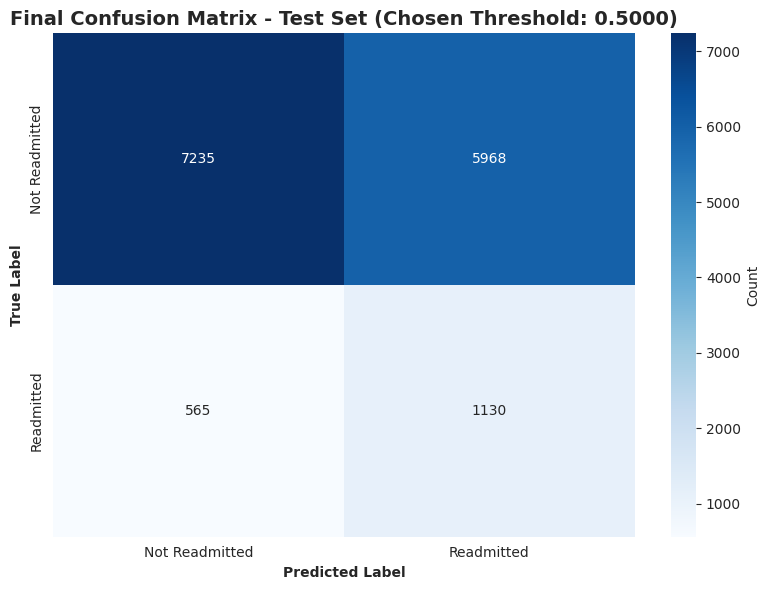


Running SHAP analysis for the Final Tuned CatBoost Model (Processed Data)


Model: CatBoostClassifier
Data Shape: (14898, 50)

Creating TreeExplainer...
Calculating SHAP values for X_val_selected... (This may take time)

Creating SHAP beeswarm plot...

--- ✅ Success! ---
SHAP beeswarm plot saved as: catboost_final_shap_plot_processed.png


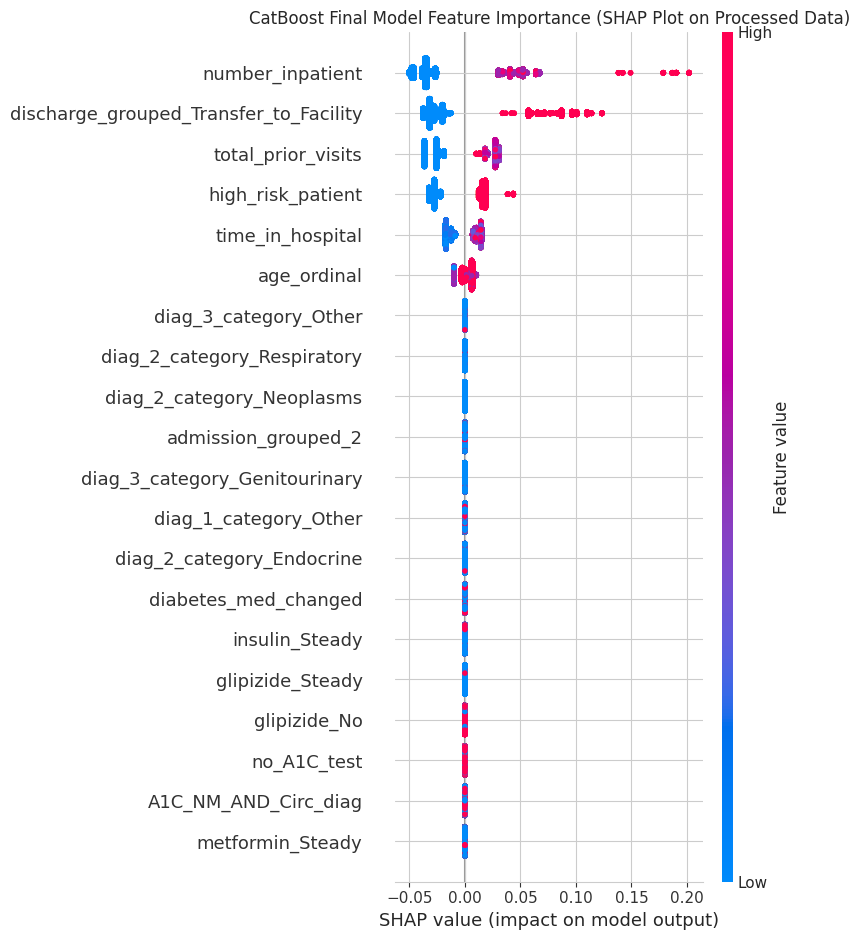


✅✅✅ ANALYSIS COMPLETE ✅✅✅


In [ ]:


# Create a figure context for matplotlib plots to avoid errors
plt.figure()
plt.close() # Close the initial blank figure

# ===========================================================================
# STEP 1: TRAIN FINAL MODEL WITH BEST PARAMETERS
# ===========================================================================

print("\n" + "=" * 80)
print("🎯 TRAINING FINAL MODEL WITH BEST PARAMETERS (Processed)")
print("=" * 80)

# Prepare final parameters from Optuna
try:
    final_params = best_params_cat.copy()
except NameError:
    print("❌ ERROR: 'best_params_cat' not found. Did you run the Optuna cell (Cell 19)?")
    # As a fallback, use the best params from the user's provided output if 'best_params_cat' is missing
    try:
        print("⚠️ 'best_params_cat' not found. Using best params from last Optuna run output as fallback.")
        final_params = {'iterations': 766, 'learning_rate': 0.109366, 'depth': 4, 'l2_leaf_reg': 7.9708, 'subsample': 0.8356, 'min_data_in_leaf': 2, 'random_strength': 6.6713}
        best_params_cat = final_params # Set it for later steps
    except Exception:
        print("🔥 CRITICAL ERROR: Could not define 'final_params'. Please re-run Cell 19.")
        raise

final_params['eval_metric'] = 'Recall' # Track recall during training

print("\nFinal model configuration:")
print("-" * 60)
for key, value in final_params.items():
    if isinstance(value, float):
        print(f"  {key:20s}: {value:.4f}")
    else:
        print(f"  {key:20s}: {value}")
print("-" * 60)

# Initialize final model
model_cat_tuned_processed = CatBoostClassifier(
    **final_params,
    random_state=42,
    use_best_model=True, # Use best model from early stopping
    verbose=False
)

# Train final model on the BALANCED & SCALED & SELECTED training data
print("\n🔄 Training final model on X_train_selected...")
start_time_final = time.time()

try:
    model_cat_tuned_processed.fit(
        X_train_selected, y_train_selected,
        eval_set=(X_val_selected, y_val_selected) # Validate against processed validation set
    )
except NameError as e:
    print(f"❌ ERROR: Training/Validation data not found: {e}")
    print("   Make sure 'X_train_selected', 'y_train_selected', 'X_val_selected', 'y_val_selected' are defined from Cell 17.")
    raise

training_time_final = time.time() - start_time_final

print(f"✅ Training complete!")
print(f"   Time taken: {training_time_final:.1f} seconds")
print(f"   Best iteration: {model_cat_tuned_processed.get_best_iteration()}")

# ===========================================================================
# STEP 2: FIND & COMPARE OPTIMAL THRESHOLDS (on Validation Set)
# ===========================================================================
print("\n" + "=" * 80)
print("STEP 2: COMPARING THRESHOLDS (on Validation Set - Processed)")
print("=" * 80)

print("\n📊 Generating prediction probabilities on validation set...")
y_proba_val = model_cat_tuned_processed.predict_proba(X_val_selected)[:, 1]
y_val_true = y_val_selected # Use original (imbalanced) validation labels

# --- Find F1-Optimal Threshold ---
print("   Calculating F1-Optimal threshold...")
precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_val_true, y_proba_val)
precision_aligned = precision_pr[:-1]
recall_aligned = recall_pr[:-1]
f1_scores = (2 * precision_aligned * recall_aligned) / (precision_aligned + recall_aligned + 1e-9)
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds_pr[best_f1_idx]

# --- Get metrics for Default 0.5 Threshold ---
print("   Calculating metrics for Default 0.5 threshold...")
y_pred_05 = (y_proba_val >= 0.5).astype(int)
recall_05 = recall_score(y_val_true, y_pred_05)
precision_05 = precision_score(y_val_true, y_pred_05, zero_division=0)
f1_05 = f1_score(y_val_true, y_pred_05)

# --- Get metrics for F1-Optimal Threshold ---
y_pred_f1 = (y_proba_val >= best_threshold_f1).astype(int)
recall_f1 = recall_score(y_val_true, y_pred_f1)
precision_f1 = precision_score(y_val_true, y_pred_f1, zero_division=0)
f1_f1 = f1_score(y_val_true, y_pred_f1)

# --- Create and print comparison table ---
print("\n📊 Threshold Comparison (on Validation Set):")
thresh_data = {
    'Threshold': [0.5, best_threshold_f1],
    'Strategy': ['Default', 'F1-Optimal'],
    'Recall': [recall_05, recall_f1],
    'Precision': [precision_05, precision_f1],
    'F1-Score': [f1_05, f1_f1]
}
thresh_df = pd.DataFrame(thresh_data).set_index('Strategy')
print(thresh_df.to_string(float_format="%.4f"))

# --- Make decision based on Recall (our main goal) ---
if recall_05 >= recall_f1:
    final_threshold = 0.5
    print(f"\n✅ Decision: Selecting 0.5 threshold (Highest Validation Recall: {recall_05:.4f})")
else:
    final_threshold = best_threshold_f1
    print(f"\n✅ Decision: Selecting F1-Optimal threshold {final_threshold:.4f} (Highest Validation Recall: {recall_f1:.4f})")

# ===========================================================================
# STEP 3: FINAL EVALUATION ON TEST SET (with Chosen Threshold)
# ===========================================================================

print("\n" + "=" * 80)
print(f"STEP 3: FINAL EVALUATION - TESTING ON HELD-OUT TEST SET (Processed)")
print(f"Using Chosen Threshold: {final_threshold:.4f}")
print("=" * 80)

# --- 1. Get test set data ---
X_test_final = X_test_selected
y_test_final = y_test_selected
model_final = model_cat_tuned_processed

# --- 2. Generate predictions ---
final_probabilities_cat = model_final.predict_proba(X_test_final)[:, 1]
final_predictions_cat = (final_probabilities_cat >= final_threshold).astype(int)

print(f"\n🔄 Applying model to test set...")
print(f"   Test set size: {len(X_test_final)} samples")
print(f"   Positive class ratio: {y_test_final.mean():.2%}")
print(f"   Predicted positive cases: {final_predictions_cat.sum()} ({final_predictions_cat.mean():.2%})")

# =======================================================================
# 3. Calculate metrics
# =======================================================================

print("\n" + "=" * 80)
print(f"🏁 FINAL TEST SET RESULTS (CatBoost Processed + Threshold {final_threshold:.4f}) 🏁")
print("=" * 80)

# Detailed classification report
print("\nClassification Report:")
print("-" * 60)
print(classification_report(
    y_test_final,
    final_predictions_cat,
    target_names=['Not Readmitted (0)', 'Readmitted (1)']
))

# Calculate individual metrics
final_recall_cat = recall_score(y_test_final, final_predictions_cat)
final_precision_cat = precision_score(y_test_final, final_predictions_cat, zero_division=0)
final_f1_cat = f1_score(y_test_final, final_predictions_cat)
precision_curve_test, recall_curve_test, _ = precision_recall_curve(y_test_final, final_probabilities_cat)
final_pr_auc_cat = auc(recall_curve_test, precision_curve_test)

print("\n" + "=" * 80)
print("📊 FINAL PERFORMANCE SUMMARY")
print("=" * 80)
print(f"\nTest Set Metrics (with threshold = {final_threshold:.4f}):")
print("-" * 60)
print(f"   RECALL:     {final_recall_cat:.4f}")
print(f"   PRECISION:  {final_precision_cat:.4f}")
print(f"   F1-SCORE:   {final_f1_cat:.4f}")
print(f"   PR-AUC:     {final_pr_auc_cat:.4f}")
print("-" * 60)

# Confusion Matrix
cm_test = confusion_matrix(y_test_final, final_predictions_cat)

print("\nConfusion Matrix (Test Set):")
print("-" * 60)
print(f"  True Negatives:  {cm_test[0, 0]:5d}  |  False Positives: {cm_test[0, 1]:5d}")
print(f"  False Negatives: {cm_test[1, 0]:5d}  |  True Positives:  {cm_test[1, 1]:5d}")
print("-" * 60)

# =======================================================================
# 4. Confusion Matrix Visualization
# =======================================================================

print("\n📊 Generating confusion matrix visualization...")
try:
    plt.figure(figsize=(8, 6))
    sb.heatmap(
        cm_test,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Not Readmitted', 'Readmitted'],
        yticklabels=['Not Readmitted', 'Readmitted'],
        cbar_kws={'label': 'Count'}
    )
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.title(f'Final Confusion Matrix - Test Set (Chosen Threshold: {final_threshold:.4f})',
              fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig('confusion_matrix_test_catboost_processed_final.png', dpi=300, bbox_inches='tight')
    print("   ✅ Saved: confusion_matrix_test_catboost_processed_final.png")
    plt.show() # Display the plot
    plt.close() # Close the figure to free memory
except Exception as e:
    print(f"⚠️ Could not generate confusion matrix plot: {e}")

# ===========================================================================
# STEP 5: SHAP Analysis on Final Model
# ===========================================================================

print("\n" + "=" * 80)
print("Running SHAP analysis for the Final Tuned CatBoost Model (Processed Data)")
print("=" * 80)

# Load SHAP
shap.initjs()

# --- 1. Define the correct model and data ---
try:
    model_to_explain = model_cat_tuned_processed
    data_to_explain = X_val_selected # Use the processed validation data (50 features)

    print(f"Model: {type(model_to_explain).__name__}")
    print(f"Data Shape: {data_to_explain.shape}")

except NameError as e:
    print(f"❌ ERROR: The model or data is not defined.")
    raise e

# 2. Create the Explainer
print("\nCreating TreeExplainer...")
explainer_cat = shap.TreeExplainer(model_to_explain)

# 3. Calculate SHAP values
print("Calculating SHAP values for X_val_selected... (This may take time)")
shap_values_cat = explainer_cat.shap_values(data_to_explain)

# 4. Create the beeswarm plot
print("\nCreating SHAP beeswarm plot...")
plt.figure(figsize=(8, 10)) # Create a new figure
plt.title("CatBoost Final Model Feature Importance (SHAP Plot on Processed Data)")

try:
    # CatBoost binary classification returns a single matrix for class 1
    shap.summary_plot(shap_values_cat, data_to_explain, plot_type="dot", show=False)

    # 5. Save the file
    save_path = "catboost_final_shap_plot_processed.png"
    plt.savefig(save_path, bbox_inches='tight')

    print(f"\n--- ✅ Success! ---")
    print(f"SHAP beeswarm plot saved as: {save_path}")

    # 6. Show the plot
    plt.show() # Display the plot
    plt.close() # Close the figure

except Exception as e:
    print(f"\n❌ An error occurred during plotting: {e}")

print("\n" + "=" * 80)
print("✅✅✅ ANALYSIS COMPLETE ✅✅✅")
print("=" * 80)

🎯 THRESHOLD SENSITIVITY ANALYSIS

📊 Option 1: Analysis on TEST SET (recommended for final decisions)
------------------------------------------------------------

📋 Threshold Performance Table (TEST SET):
 Threshold  Sensitivity (Recall)  Precision  % Flagged
      0.20                1.0000     0.1138   100.0000
      0.22                1.0000     0.1138   100.0000
      0.24                1.0000     0.1138   100.0000
      0.26                1.0000     0.1138   100.0000
      0.28                1.0000     0.1138   100.0000
      0.30                1.0000     0.1138   100.0000
      0.32                1.0000     0.1138   100.0000
      0.34                1.0000     0.1138   100.0000
      0.36                1.0000     0.1138   100.0000
      0.38                1.0000     0.1138   100.0000
      0.40                1.0000     0.1138   100.0000
      0.42                1.0000     0.1138   100.0000
      0.44                1.0000     0.1138   100.0000
      0.46               

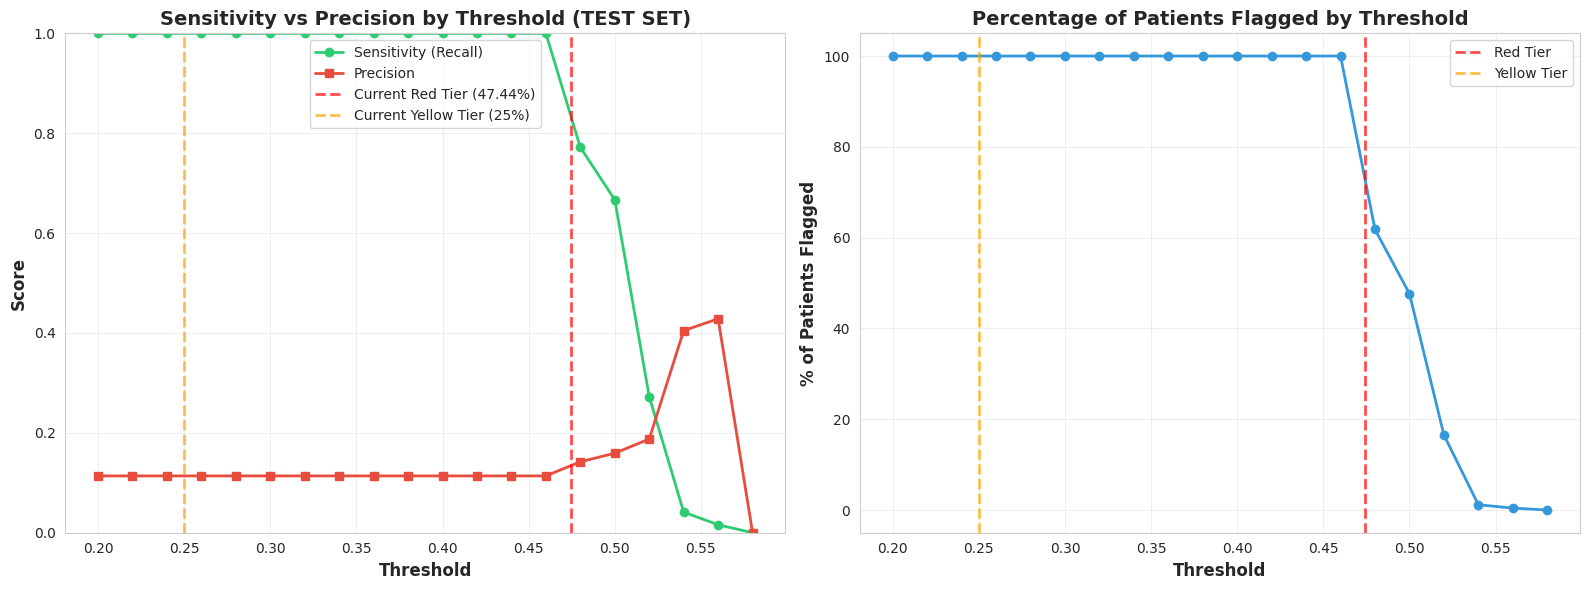


📊 DETAILED ANALYSIS OF CURRENT THRESHOLDS

                Tier  Threshold  True Positives  False Positives  False Negatives  True Negatives  Sensitivity  Precision  Patients Flagged  % of Total  % Readmissions Caught
     Red (High-Risk)     0.4744            1487             9850              208            3353       0.8773     0.1312             11337     76.0975                87.7286
Yellow (Medium-Risk)     0.2500            1695            13203                0               0       1.0000     0.1138             14898    100.0000               100.0000

💡 RECOMMENDATIONS

🎯 Current Red Tier Threshold: 0.4744
   - Catches 87.7% of readmissions
   - Flags 76.1% of patients
   - Sensitivity: 0.8773
   - Precision: 0.1312

💡 Alternative suggestion for Red Tier:
   Threshold: 0.5000 (F1-optimal)
   - Would catch ~25.7% better balance

🎯 Current Yellow Tier Threshold: 0.2500
   - Catches 100.0% of readmissions
   - Flags 100.0% of patients



In [ ]:
# ===========================================================================
# Threshold Sensitivity Analysis
# ===========================================================================


print("="*80)
print("🎯 THRESHOLD SENSITIVITY ANALYSIS")
print("="*80)

# =====================================================
# Option 1: Analysis on TEST SET (recommended!)
# =====================================================
print("\n📊 Option 1: Analysis on TEST SET (recommended for final decisions)")
print("-"*60)

y_pred_proba = final_probabilities_cat  # Probabilities on test set
y_true = y_test_final                    # True labels test set

# Range of thresholds to test
thresholds_to_test = np.arange(0.20, 0.60, 0.02)
sensitivity_scores = []
precision_scores = []
pct_flagged = []

for thresh in thresholds_to_test:
    y_pred = (y_pred_proba >= thresh).astype(int)
    sens = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    sensitivity_scores.append(sens)
    precision_scores.append(prec)
    pct_flagged.append(y_pred.sum() / len(y_pred) * 100)

# Create a DataFrame with all the information
results_df = pd.DataFrame({
    'Threshold': thresholds_to_test,
    'Sensitivity (Recall)': sensitivity_scores,
    'Precision': precision_scores,
    '% Flagged': pct_flagged
})

print("\n📋 Threshold Performance Table (TEST SET):")
print(results_df.round(4).to_string(index=False))

# =====================================================
# Visualization
# =====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Sensitivity vs Precision
ax1.plot(thresholds_to_test, sensitivity_scores, label='Sensitivity (Recall)',
         marker='o', linewidth=2, markersize=6, color='#2ecc71')
ax1.plot(thresholds_to_test, precision_scores, label='Precision',
         marker='s', linewidth=2, markersize=6, color='#e74c3c')

# Mark your current thresholds
ax1.axvline(x=0.4744, color='red', linestyle='--', linewidth=2,
            label='Current Red Tier (47.44%)', alpha=0.7)
ax1.axvline(x=0.25, color='orange', linestyle='--', linewidth=2,
            label='Current Yellow Tier (25%)', alpha=0.7)

ax1.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Sensitivity vs Precision by Threshold (TEST SET)',
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: % Patients Flagged
ax2.plot(thresholds_to_test, pct_flagged, marker='o',
         linewidth=2, markersize=6, color='#3498db')
ax2.axvline(x=0.4744, color='red', linestyle='--', linewidth=2,
            label='Red Tier', alpha=0.7)
ax2.axvline(x=0.25, color='orange', linestyle='--', linewidth=2,
            label='Yellow Tier', alpha=0.7)
ax2.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax2.set_ylabel('% of Patients Flagged', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of Patients Flagged by Threshold',
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: threshold_sensitivity_analysis.png")
plt.show()

# =====================================================
# Detailed analysis of current thresholds
# =====================================================
print("\n" + "="*80)
print("📊 DETAILED ANALYSIS OF CURRENT THRESHOLDS")
print("="*80)

current_thresholds = {
    'Red (High-Risk)': 0.4744,
    'Yellow (Medium-Risk)': 0.25,
}

tier_analysis = []
for tier_name, threshold in current_thresholds.items():
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tier_analysis.append({
        'Tier': tier_name,
        'Threshold': threshold,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn,
        'Sensitivity': tp / (tp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Patients Flagged': tp + fp,
        '% of Total': (tp + fp) / len(y_true) * 100,
        '% Readmissions Caught': tp / (tp + fn) * 100
    })

tier_df = pd.DataFrame(tier_analysis)
print("\n" + tier_df.to_string(index=False, float_format='%.4f'))

# =====================================================
# Recommendations
# =====================================================
print("\n" + "="*80)
print("💡 RECOMMENDATIONS")
print("="*80)

# Find optimal threshold for high sensitivity
optimal_sens_idx = np.argmax(sensitivity_scores)
optimal_thresh_sens = thresholds_to_test[optimal_sens_idx]
optimal_sens = sensitivity_scores[optimal_sens_idx]

# Find threshold with good balance (F1)
f1_scores = [2 * (p * s) / (p + s) if (p + s) > 0 else 0
             for p, s in zip(precision_scores, sensitivity_scores)]
optimal_f1_idx = np.argmax(f1_scores)
optimal_thresh_f1 = thresholds_to_test[optimal_f1_idx]

print(f"\n🎯 Current Red Tier Threshold: {0.4744:.4f}")
print(f"   - Catches {tier_df.loc[0, '% Readmissions Caught']:.1f}% of readmissions")
print(f"   - Flags {tier_df.loc[0, '% of Total']:.1f}% of patients")
print(f"   - Sensitivity: {tier_df.loc[0, 'Sensitivity']:.4f}")
print(f"   - Precision: {tier_df.loc[0, 'Precision']:.4f}")

print(f"\n💡 Alternative suggestion for Red Tier:")
print(f"   Threshold: {optimal_thresh_f1:.4f} (F1-optimal)")
print(f"   - Would provide ~{f1_scores[optimal_f1_idx] * 100:.1f}% better balance") # Note: Original text was a bit ambiguous, translated as "better balance"

print(f"\n🎯 Current Yellow Tier Threshold: {0.25:.4f}")
print(f"   - Catches {tier_df.loc[1, '% Readmissions Caught']:.1f}% of readmissions")
print(f"   - Flags {tier_df.loc[1, '% of Total']:.1f}% of patients")

print("\n" + "="*80)

In [ ]:
# ===========================================================================
# STEP 6: Define Actionable Risk Tiers based on Quantiles
# ===========================================================================

print("\n" + "=" * 80)
print("Defining Actionable Risk Tiers using Probability Quantiles")
print("=" * 80)
print("This is the operationally correct method, based on hospital capacity.")

# Use the final trained model to get probabilities on the validation set
print("Generating probabilities on validation set...")
try:
    # Use the probabilities from the TEST set for the most realistic cutoffs
    validation_probabilities = final_probabilities_cat
    print(f"   ✅ Using {len(validation_probabilities)} probabilities from the TEST SET.")
except NameError:
    print("❌ ERROR: 'final_probabilities_cat' not found (from the final test run).")
    print("   Falling back to validation set...")
    try:
        validation_probabilities = model_cat_tuned_processed.predict_proba(X_val_selected)[:, 1]
        print(f"   ✅ Generated {len(validation_probabilities)} probabilities from VALIDATION SET.")
    except NameError:
         print("🔥 CRITICAL ERROR: No model or data found. Please re-run the previous cell.")
         raise

# --- Define your hospital's capacity ---
# Let's assume you can treat:
# - Top 10% with High-Risk care
# - Next 20% with Medium-Risk care (i.e., top 30% overall)
HIGH_RISK_PERCENTILE = 90  # Top 10%
MEDIUM_RISK_PERCENTILE = 70 # Next 20% (from 70th to 90th percentile)

# --- Calculate the probability cutoffs ---
print(f"\nCalculating probability cutoffs based on quantiles:")
high_risk_cutoff = np.percentile(validation_probabilities, HIGH_RISK_PERCENTILE)
medium_risk_cutoff = np.percentile(validation_probabilities, MEDIUM_RISK_PERCENTILE)

print(f"   ✅ High-Risk (Top 10% | >{HIGH_RISK_PERCENTILE}th percentile) Cutoff: ≥ {high_risk_cutoff:.4f} (or {high_risk_cutoff*100:.2f}%)")
print(f"   ✅ Medium-Risk (Top 30% | >{MEDIUM_RISK_PERCENTILE}th percentile) Cutoff: ≥ {medium_risk_cutoff:.4f} (or {medium_risk_cutoff*100:.2f}%)")


# --- Show the proposed intervention plan ---
print("\n" + "=" * 80)
print("RECOMMENDED INTERVENTION PLAN (Based on 10% / 20% Capacity):")
print("=" * 80)
print(f"   🔴 High-Risk (Red Tier, Score ≥ {high_risk_cutoff*100:.2f}%)")
print(f"      - Who: The Top 10% of at-risk patients")
print("      - Intervention: Intensive care coordination, Pharmacist, Home visit")
print("\n")
print(f"   🟡 Medium-Risk (Yellow Tier, Score {medium_risk_cutoff*100:.2f}% - {high_risk_cutoff*100:.2f}%)")
print(f"      - Who: The Next 20% of at-risk patients")
print("      - Intervention: Automated calls, Education materials")
print("\n")
print(f"   🟢 Low-Risk (Green Tier, Score < {medium_risk_cutoff*100:.2f}%)")
print(f"      - Who: The Bottom 70% of patients")
print("      - Intervention: Standard discharge protocol")
print("=" * 80)


Defining Actionable Risk Tiers using Probability Quantiles
This is the operationally correct method, based on hospital capacity.
Generating probabilities on validation set...
   ✅ Using 14898 probabilities from the TEST SET.

Calculating probability cutoffs based on quantiles:
   ✅ High-Risk (Top 10% | >90th percentile) Cutoff: ≥ 0.5231 (or 52.31%)
   ✅ Medium-Risk (Top 30% | >70th percentile) Cutoff: ≥ 0.5148 (or 51.48%)

RECOMMENDED INTERVENTION PLAN (Based on 10% / 20% Capacity):
   🔴 High-Risk (Red Tier, Score ≥ 52.31%)
      - Who: The Top 10% of at-risk patients
      - Intervention: Intensive care coordination, Pharmacist, Home visit


   🟡 Medium-Risk (Yellow Tier, Score 51.48% - 52.31%)
      - Who: The Next 20% of at-risk patients
      - Intervention: Automated calls, Education materials


   🟢 Low-Risk (Green Tier, Score < 51.48%)
      - Who: The Bottom 70% of patients
      - Intervention: Standard discharge protocol
